In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score 
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor 

### 1. Loading dataset

The data used for this project come from: https://www.kaggle.com/competitions/playground-series-s6e1

In [2]:
dataset_train = pd.read_csv("train.csv")
dataset_test = pd.read_csv("test.csv")

**1.1 Train Dataset - EDA**

**1.1.1. Understanding the data**

In [3]:
dataset_train.head()

,id,age,gender,course,study_hours,class_attendance,internet_access,sleep_hours,sleep_quality,study_method,facility_rating,exam_difficulty,exam_score
0,0,21,female,b.sc,7.91,98.8,no,4.9,average,online videos,low,easy,78.3
1,1,18,other,diploma,4.95,94.8,yes,4.7,poor,self-study,medium,moderate,46.7
2,2,20,female,b.sc,4.68,92.6,yes,5.8,poor,coaching,high,moderate,99.0
3,3,19,male,b.sc,2.00,49.5,yes,8.3,average,group study,high,moderate,63.9
4,4,23,male,bca,7.65,86.9,yes,9.6,good,self-study,high,easy,100.0


This table shows a subset of the Prediction Score dataset used for a regression task. The dataset consists of twelve features and one target variable (exam_score). Four features are numerical (age, study_hours, class_attendance, and sleep_hours), one is binary categorical (internet_access), and six are categorical, including both nominal (gender, course, and study_method) and ordinal (sleep_quality, facility_rating, and exam_difficulty) variables. The remaining field is an identifier (id).

In [4]:
dataset_train.describe()

,id,age,study_hours,class_attendance,sleep_hours,exam_score
count,630000.000000,630000.000000,630000.000000,630000.000000,630000.000000,630000.000000
mean,314999.500000,20.545821,4.002337,71.987261,7.072758,62.506672
std,181865.479132,2.260238,2.359880,17.430098,1.744811,18.916884
min,0.000000,17.000000,0.080000,40.600000,4.100000,19.599000
25%,157499.750000,19.000000,1.970000,57.000000,5.600000,48.800000
50%,314999.500000,21.000000,4.000000,72.600000,7.100000,62.600000
75%,472499.250000,23.000000,6.050000,87.200000,8.600000,76.300000
max,629999.000000,24.000000,7.910000,99.400000,9.900000,100.000000


From the initial inspection using the describe() method, no significant outliers are observed, as the minimum and maximum values do not deviate substantially from the rest of the data. Few features exhibit mild skewness; however, the skewness is minimal and does not indicate severe distribution imbalance. The columns age, study_hours, class_attendance and sleep_hours are numerical features with values outside the range [0, 1]. Therefore, feature scaling is required to improve the performance and convergence of machine learning algorithms.

In [5]:
dataset_train.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 630000 entries, 0 to 629999
Data columns (total 13 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   id                630000 non-null  int64  
 1   age               630000 non-null  int64  
 2   gender            630000 non-null  object 
 3   course            630000 non-null  object 
 4   study_hours       630000 non-null  float64
 5   class_attendance  630000 non-null  float64
 6   internet_access   630000 non-null  object 
 7   sleep_hours       630000 non-null  float64
 8   sleep_quality     630000 non-null  object 
 9   study_method      630000 non-null  object 
 10  facility_rating   630000 non-null  object 
 11  exam_difficulty   630000 non-null  object 
 12  exam_score        630000 non-null  float64
dtypes: float64(4), int64(2), object(7)
memory usage: 62.5+ MB


The dataset contains 768 entries with no missing values.

In [6]:
dataset_train.nunique()

id                  630000
age                      8
gender                   3
course                   7
study_hours            792
class_attendance       617
internet_access          2
sleep_hours             66
sleep_quality            3
study_method             5
facility_rating          3
exam_difficulty          3
exam_score             805
dtype: int64

**1.1.2 Data Visualization**

**1.1.2.1 Label - Exam Score**

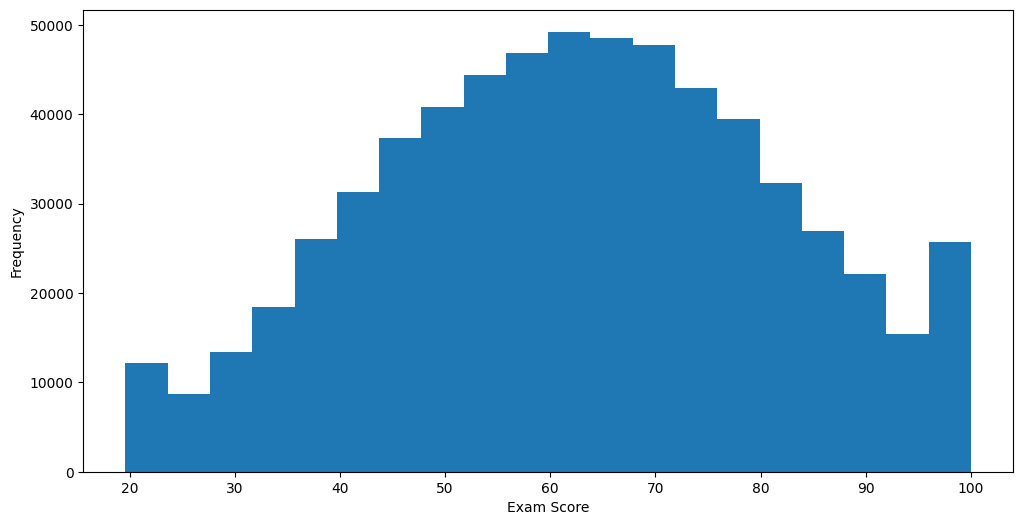

In [7]:
plt.figure(figsize=(12, 6))
plt.hist(dataset_train["exam_score"], bins=20)
plt.xlabel("Exam Score")
plt.ylabel("Frequency")
plt.show()

The dataset labels are approximately normally distributed, but the lowest (20%) and highest (100%) exam scores are overrepresented compared to a standard normal distribution. 

**1.1.2.2 - Features**

In [8]:
sns.set_style("whitegrid")
palette = "pastel"

**1.1.2.3 - Analysis of the age column**

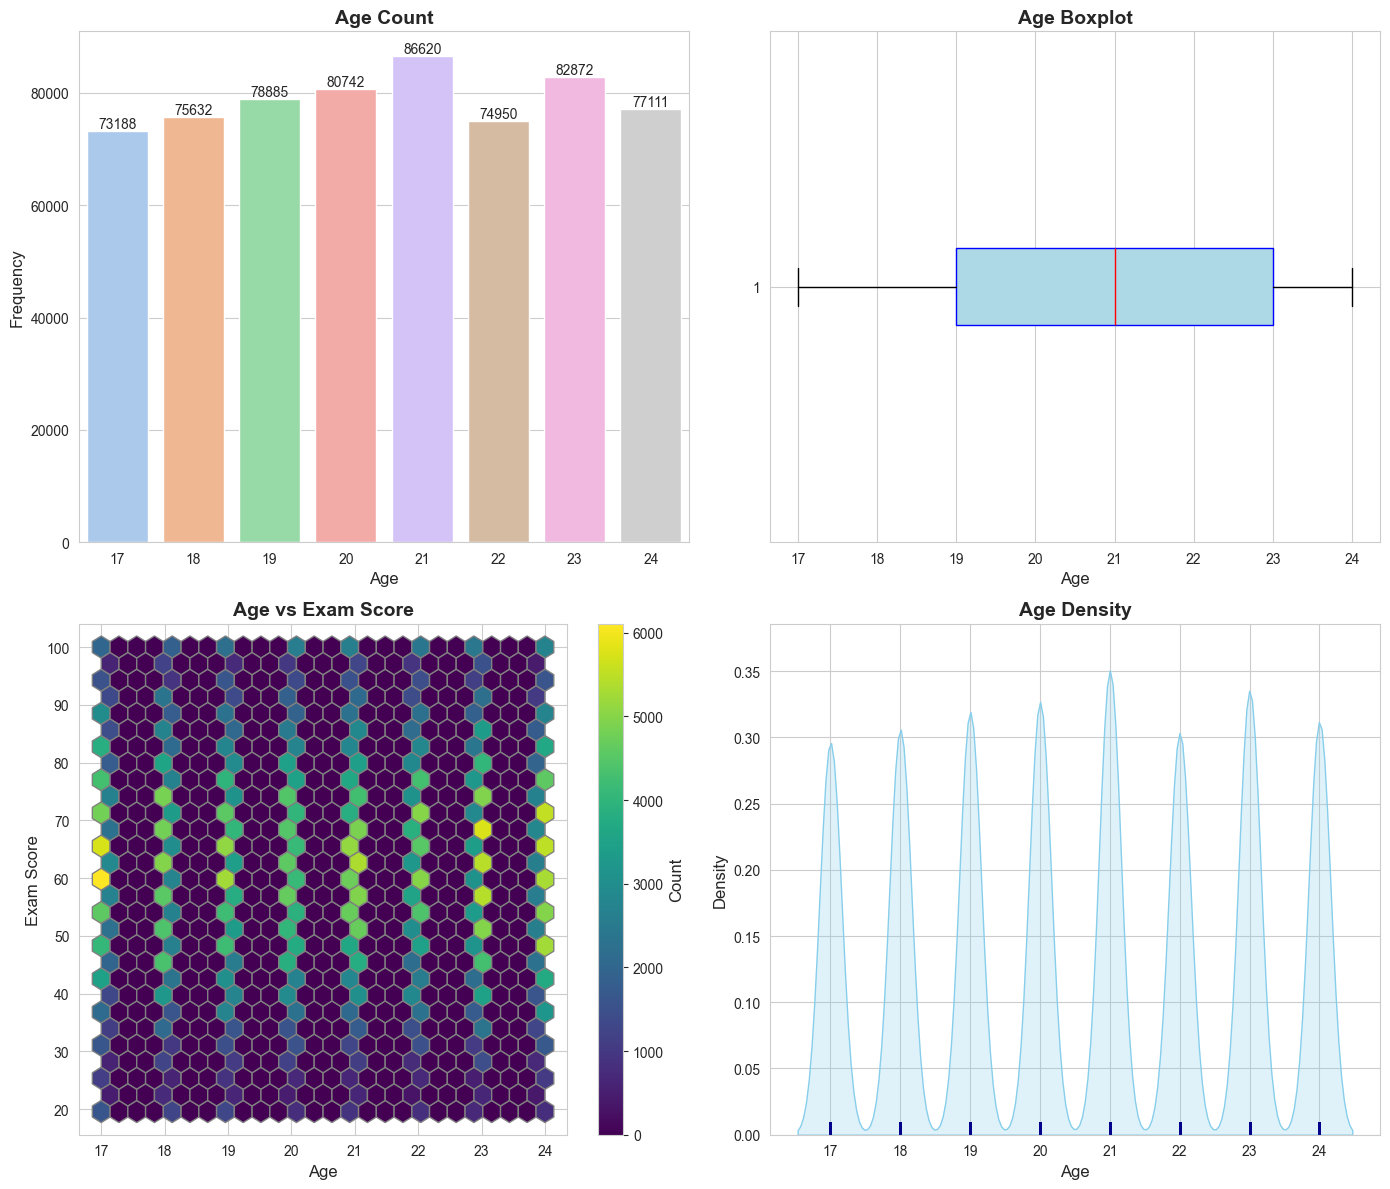

In [9]:
fig, ax = plt.subplots(2, 2, figsize=(14, 12))
ax = ax.flatten()

sns.countplot(x="age", data=dataset_train, ax=ax[0], palette=palette)
ax[0].set_title("Age Count", fontsize=14, fontweight="bold")
ax[0].set_xlabel("Age", fontsize=12)
ax[0].set_ylabel("Frequency", fontsize=12)

for p in ax[0].patches:
    ax[0].annotate(f"{int(p.get_height())}",  
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha="center", va="bottom", fontsize=10)



ax[1].boxplot(dataset_train["age"], vert=False, patch_artist=True,
              boxprops=dict(facecolor="lightblue", color="blue"),
              medianprops=dict(color="red"))
ax[1].set_xlabel("Age", fontsize=12)
ax[1].set_title("Age Boxplot", fontsize=14, fontweight="bold")



hb = ax[2].hexbin(
    dataset_train["age"],
    dataset_train["exam_score"],
    gridsize=25,
    cmap="viridis",
    edgecolors="grey"
)
cbar = plt.colorbar(hb, ax=ax[2])
cbar.set_label("Count", fontsize=12)
ax[2].set_xlabel("Age", fontsize=12)
ax[2].set_ylabel("Exam Score", fontsize=12)
ax[2].set_title("Age vs Exam Score", fontsize=14, fontweight="bold")


sns.kdeplot(dataset_train["age"], ax=ax[3], fill=True, color="skyblue")
sns.rugplot(dataset_train["age"], ax=ax[3], color="darkblue")
ax[3].set_xlabel("Age", fontsize=12)
ax[3].set_ylabel("Density", fontsize=12)
ax[3].set_title("Age Density", fontsize=14, fontweight="bold")

# Layout adjustments
plt.tight_layout()
plt.show()


By analyzing the 'age' column, several observations can be made. The frequency of each age group is fairly uniform, ranging from 73,188 for age 17 to 86,620 for age 21, which helps prevent bias toward any particular age group in predictions. The distribution is slightly left-skewed, as the mean (20.54) is slightly lower than the median (21). Additionally, there appears to be no clear relationship between age and exam scores, as most students across all age groups score roughly between 50 and 70. This suggests that age is unlikely to be a strong predictor of exam performance in this dataset.

**1.1.2.4 - Analysis of the gender column**

In [10]:
dataset_train['gender'].value_counts()

gender
other     211097
male      210593
female    208310
Name: count, dtype: int64

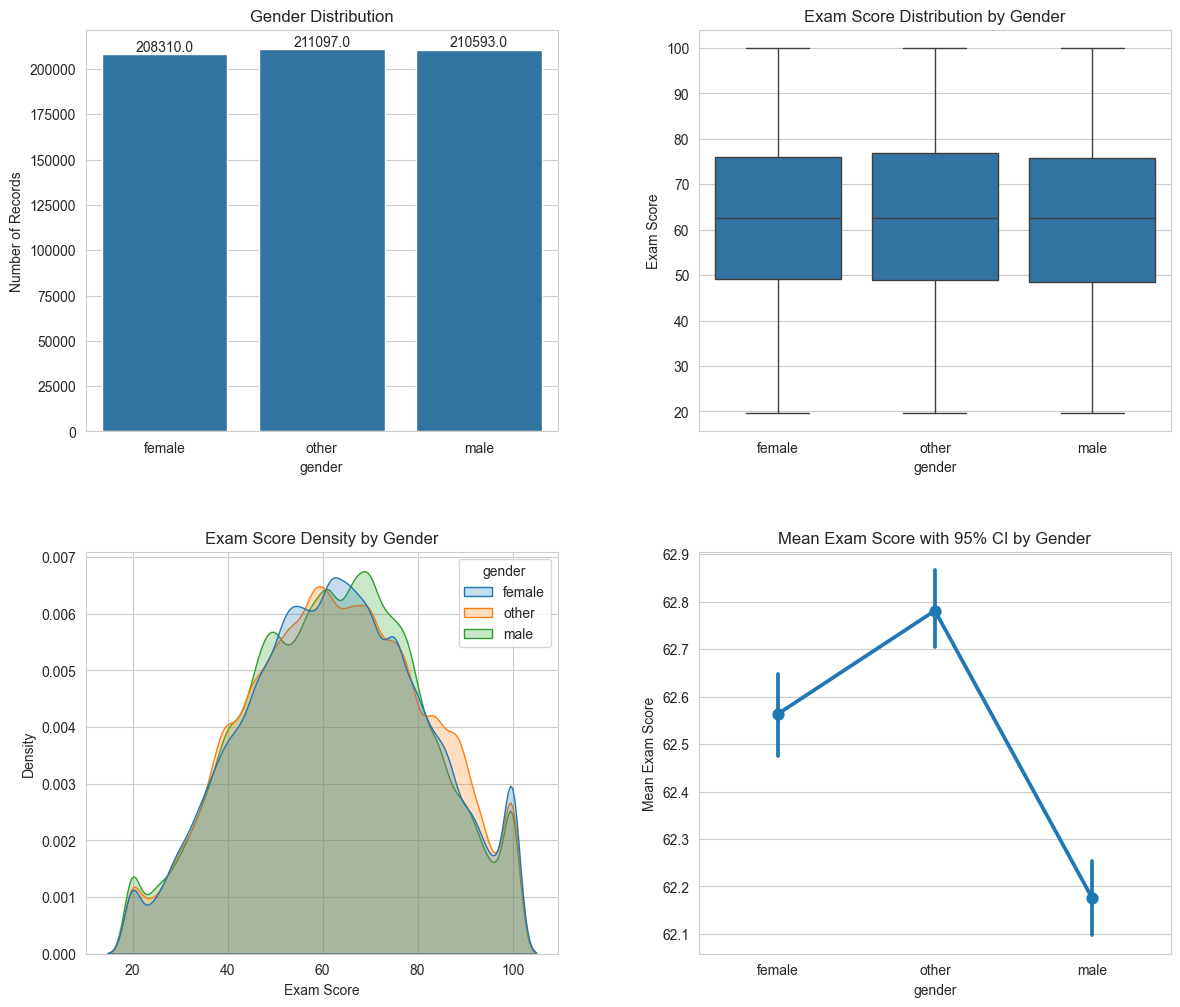

In [11]:
fig, ax = plt.subplots(2, 2, figsize=(14, 12))
ax = ax.flatten()

sns.countplot(x="gender", data=dataset_train, ax=ax[0])
for p in ax[0].patches:
    ax[0].annotate(f"{p.get_height()}", 
                 (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha="center", va="bottom")
ax[0].set_title("Gender Distribution")
ax[0].set_ylabel("Number of Records")

sns.boxplot(x="gender", y="exam_score", data=dataset_train, ax=ax[1])
ax[1].set_title("Exam Score Distribution by Gender")
ax[1].set_ylabel("Exam Score")

sns.kdeplot(data=dataset_train, x="exam_score", hue="gender", fill=True, ax=ax[2])
ax[2].set_title("Exam Score Density by Gender")
ax[2].set_xlabel("Exam Score")

sns.pointplot(x="gender", y="exam_score", data=dataset_train, ci=95, ax=ax[3])
ax[3].set_title("Mean Exam Score with 95% CI by Gender")
ax[3].set_ylabel("Mean Exam Score")


plt.subplots_adjust(hspace=0.3, wspace=0.3)
plt.show()

By analyzing the *'gender'* column, several observations can be made. The frequency of each gender category is fairly uniform, which helps prevent bias toward any particular gender group in predictions. The mean exam score is nearly identical across genders, ranging from 62.2 for males to 62.8 for the other gender category. The density plot suggests an approximately normal distribution, supporting the use of parametric statistical methods that assume normality.

**1.1.2.5 - Analysis of course column**

In [ ]:
dataset_train["course"].value_counts() 

course
b.tech     131236
b.sc       111554
b.com      110932
bca         88721
bba         75644
ba          61989
diploma     49924
Name: count, dtype: int64

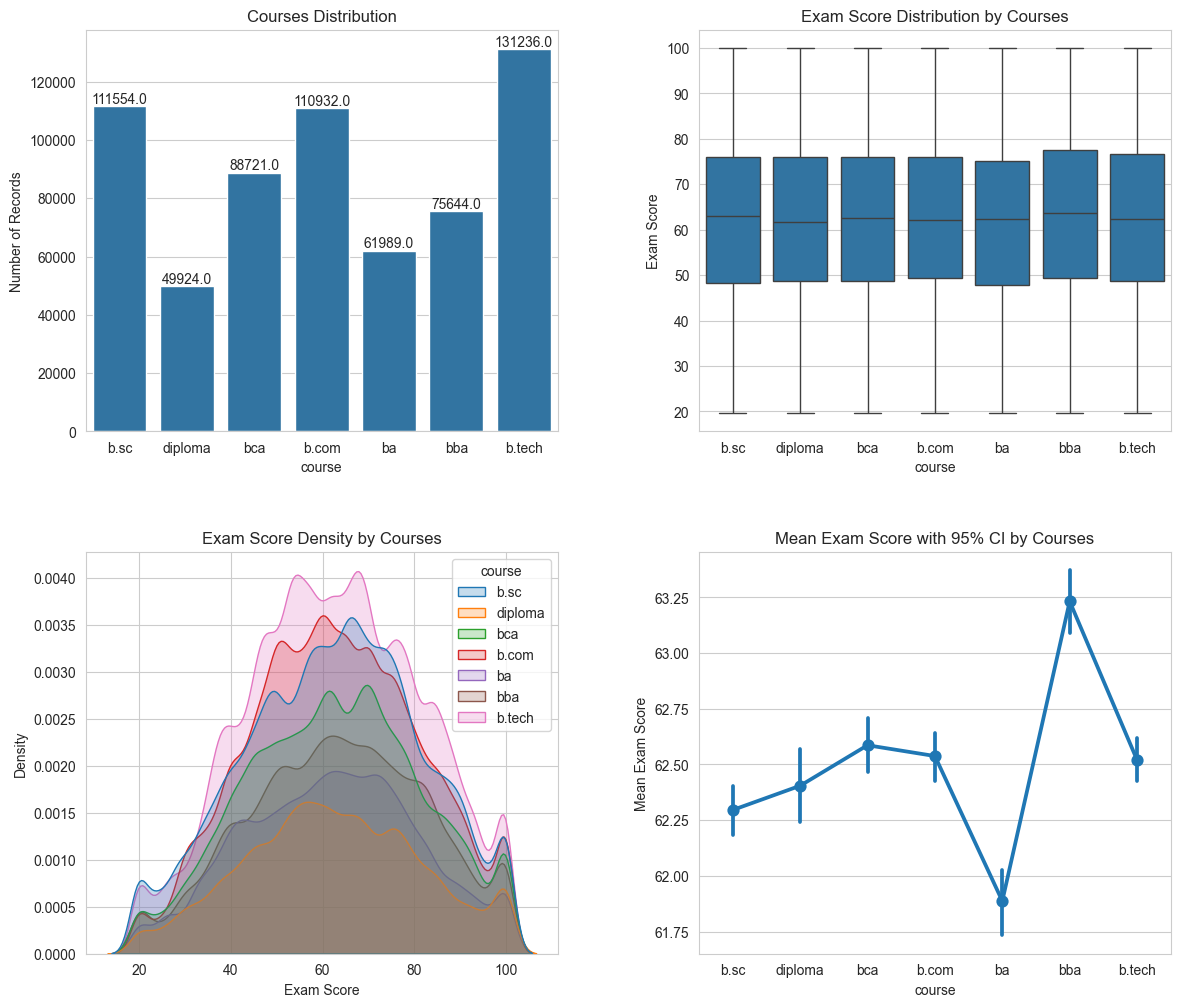

In [13]:
fig, ax = plt.subplots(2, 2, figsize=(14, 12))
ax = ax.flatten()

sns.countplot(x="course", data=dataset_train, ax=ax[0])
for p in ax[0].patches:
    ax[0].annotate(f"{p.get_height()}", 
                 (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha="center", va="bottom")
ax[0].set_title("Courses Distribution")
ax[0].set_ylabel("Number of Records")

sns.boxplot(x="course", y="exam_score", data=dataset_train,
            ax=ax[1], showfliers=False)
ax[1].set_title("Exam Score Distribution by Courses")
ax[1].set_ylabel("Exam Score")

sns.kdeplot(data=dataset_train, x="exam_score", hue="course", fill=True, ax=ax[2])
ax[2].set_title("Exam Score Density by Courses")
ax[2].set_xlabel("Exam Score")

sns.pointplot(x="course", y="exam_score", data=dataset_train, ci=95, ax=ax[3])
ax[3].set_title("Mean Exam Score with 95% CI by Courses")
ax[3].set_ylabel("Mean Exam Score")


plt.subplots_adjust(hspace=0.3, wspace=0.3)
plt.show()

**1.1.2.6 - Analysis of study hours column**

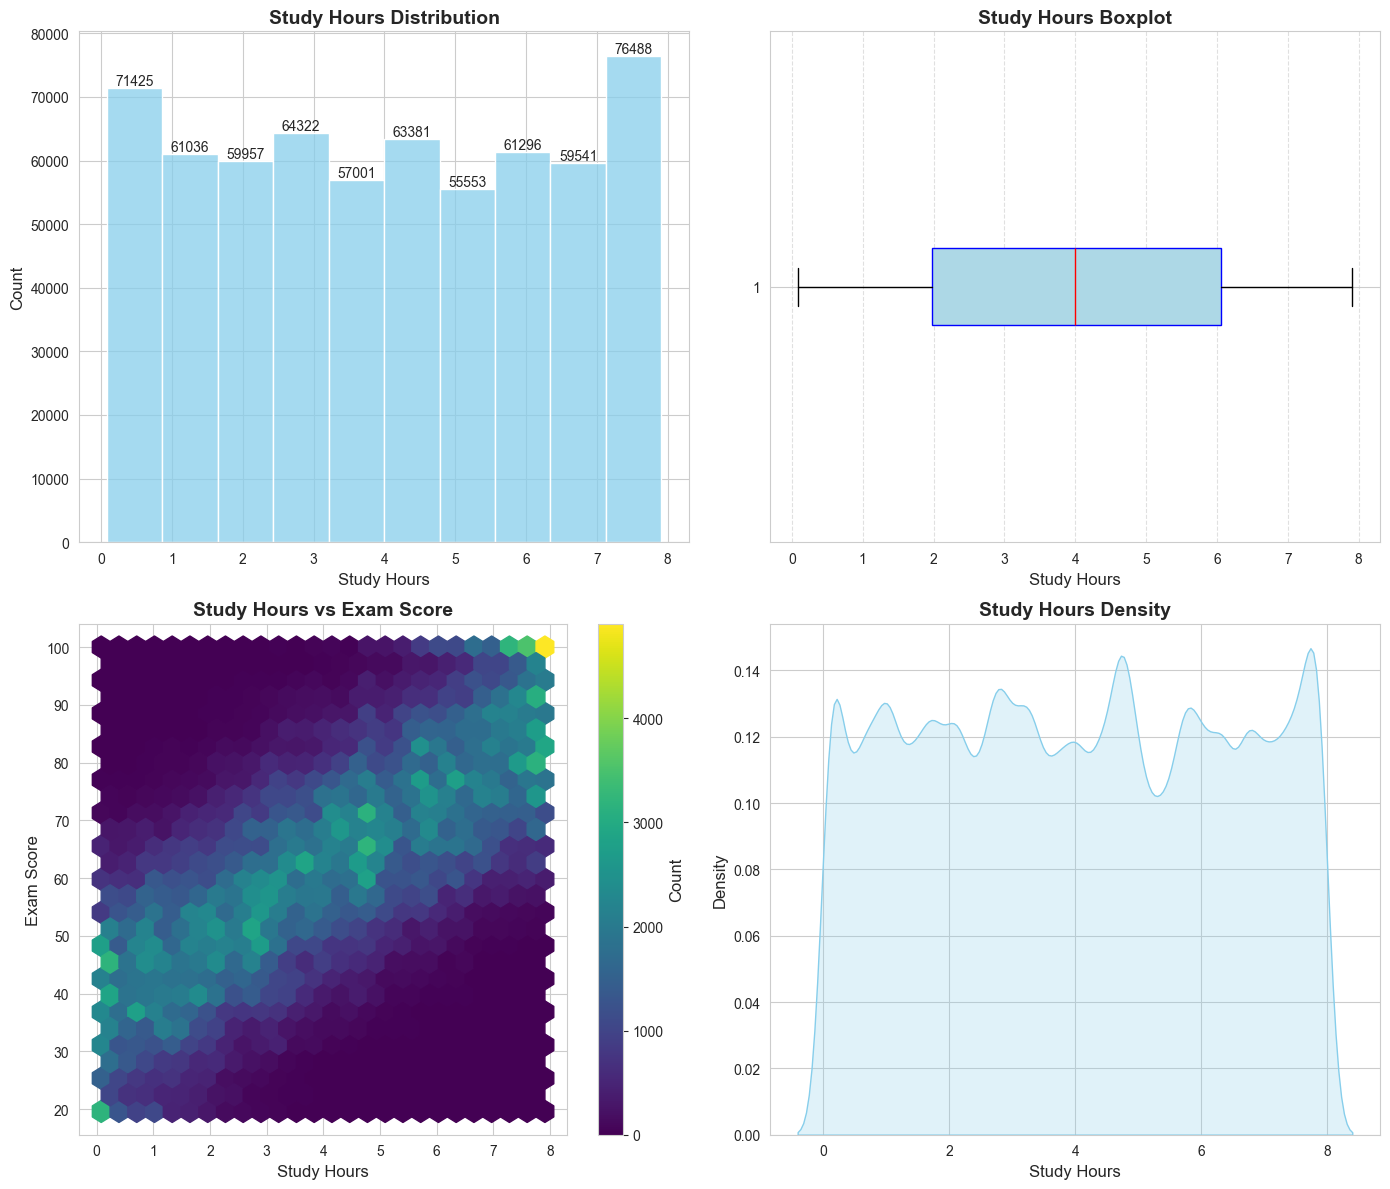

In [14]:
fig, ax = plt.subplots(2, 2, figsize=(14, 12))
ax = ax.flatten()


sns.histplot(dataset_train["study_hours"], bins=10, kde=False, ax=ax[0], color="skyblue")
ax[0].set_title("Study Hours Distribution", fontsize=14, fontweight='bold')
ax[0].set_xlabel("Study Hours", fontsize=12)
ax[0].set_ylabel("Count", fontsize=12)


for p in ax[0].patches:
    ax[0].annotate(f'{int(p.get_height())}',  
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha='center', va='bottom', fontsize=10)



ax[1].boxplot(dataset_train["study_hours"], vert=False, patch_artist=True,
              boxprops=dict(facecolor='lightblue', color='blue'),
              medianprops=dict(color='red'))
ax[1].grid(axis='x', linestyle='--', alpha=0.6)
ax[1].set_xlabel("Study Hours", fontsize=12)
ax[1].set_title("Study Hours Boxplot", fontsize=14, fontweight='bold')


hb = ax[2].hexbin(
    dataset_train["study_hours"],
    dataset_train["exam_score"],
    gridsize=25,
    cmap="viridis"
)
cbar = plt.colorbar(hb, ax=ax[2])
cbar.set_label("Count", fontsize=12)
ax[2].set_xlabel("Study Hours", fontsize=12)
ax[2].set_ylabel("Exam Score", fontsize=12)
ax[2].set_title("Study Hours vs Exam Score", fontsize=14, fontweight='bold')


sns.kdeplot(dataset_train["study_hours"], ax=ax[3], fill=True, color='skyblue')
ax[3].set_xlabel("Study Hours", fontsize=12)
ax[3].set_ylabel("Density", fontsize=12)
ax[3].set_title("Study Hours Density", fontsize=14, fontweight='bold')


plt.tight_layout()
plt.show()


**1.1.2.7 - Analysis of class attendance column**

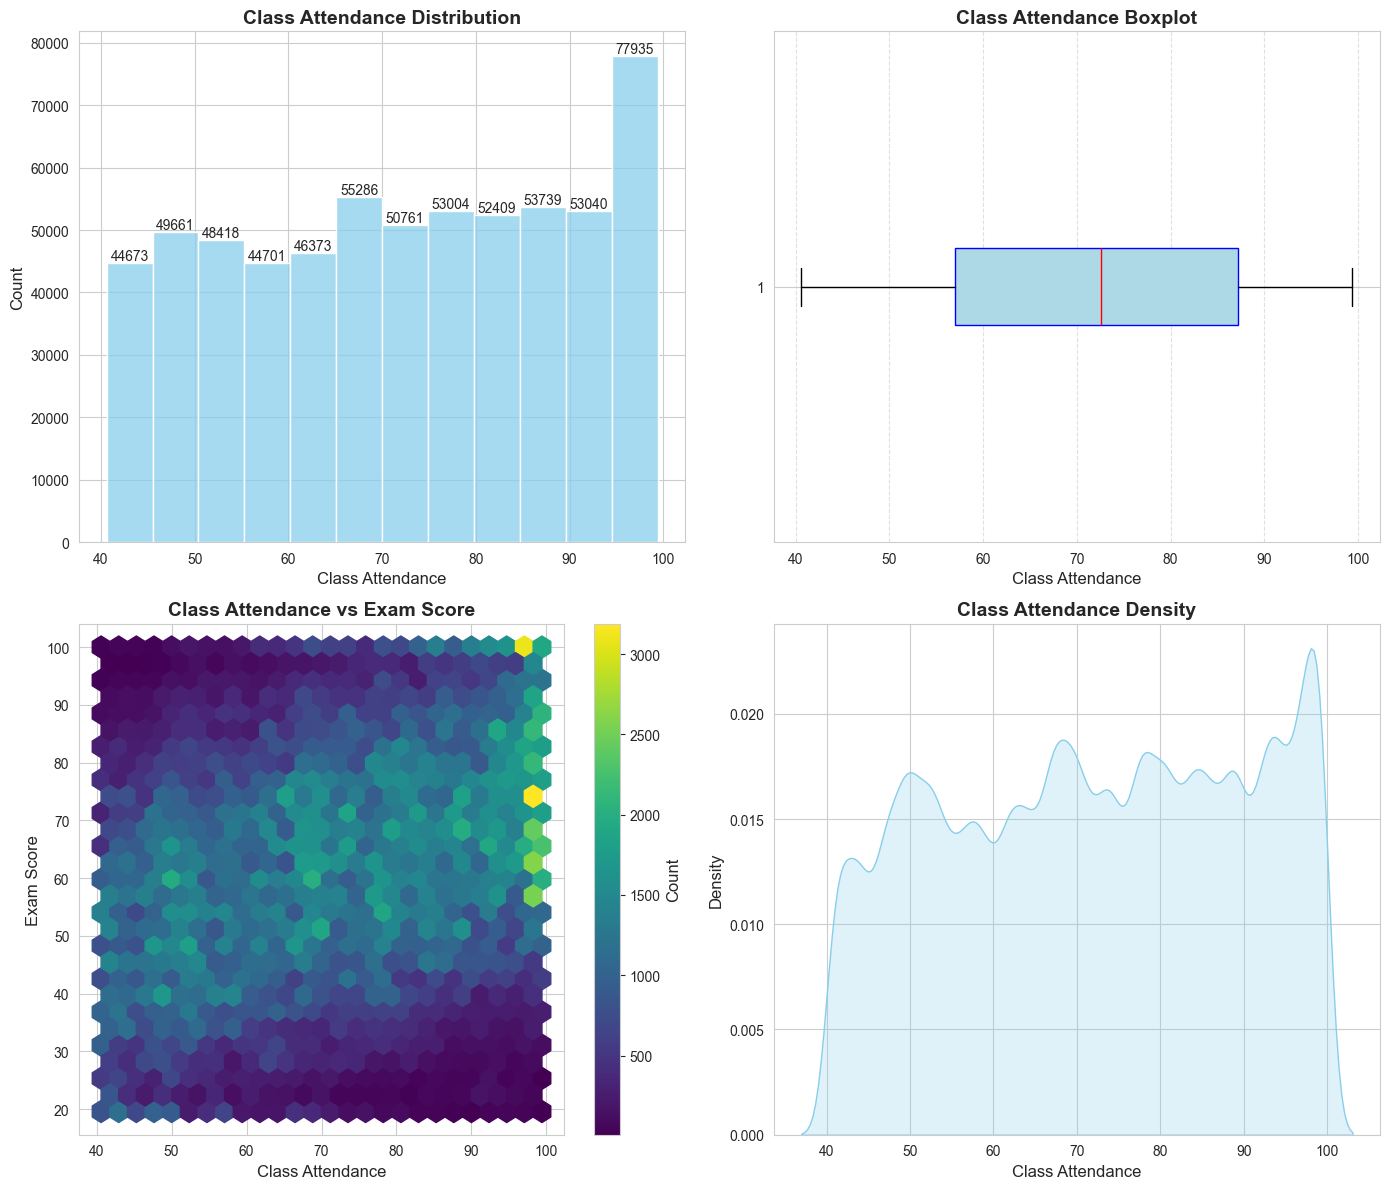

In [15]:
fig, ax = plt.subplots(2, 2, figsize=(14, 12))
ax = ax.flatten()


sns.histplot(dataset_train["class_attendance"], binwidth=5, kde=False, ax=ax[0], color="skyblue")
ax[0].set_title("Class Attendance Distribution", fontsize=14, fontweight='bold')
ax[0].set_xlabel("Class Attendance", fontsize=12)
ax[0].set_ylabel("Count", fontsize=12)

for p in ax[0].patches:
    ax[0].annotate(f'{int(p.get_height())}',  
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha='center', va='bottom', fontsize=10)


ax[1].boxplot(dataset_train["class_attendance"], vert=False, patch_artist=True,
              boxprops=dict(facecolor='lightblue', color='blue'),
              medianprops=dict(color='red'))
ax[1].grid(axis='x', linestyle='--', alpha=0.6)
ax[1].set_xlabel("Class Attendance", fontsize=12)
ax[1].set_title("Class Attendance Boxplot", fontsize=14, fontweight='bold')


hb = ax[2].hexbin(
    dataset_train["class_attendance"],
    dataset_train["exam_score"],
    gridsize=25,
    cmap="viridis"
)
cbar = plt.colorbar(hb, ax=ax[2])
cbar.set_label("Count", fontsize=12)
ax[2].set_xlabel("Class Attendance", fontsize=12)
ax[2].set_ylabel("Exam Score", fontsize=12)
ax[2].set_title("Class Attendance vs Exam Score", fontsize=14, fontweight='bold')


sns.kdeplot(dataset_train["class_attendance"], ax=ax[3], fill=True, color='skyblue')
ax[3].set_xlabel("Class Attendance", fontsize=12)
ax[3].set_ylabel("Density", fontsize=12)
ax[3].set_title("Class Attendance Density", fontsize=14, fontweight='bold')


plt.tight_layout()
plt.show()


**1.1.2.8 - Analysis of internet access column**

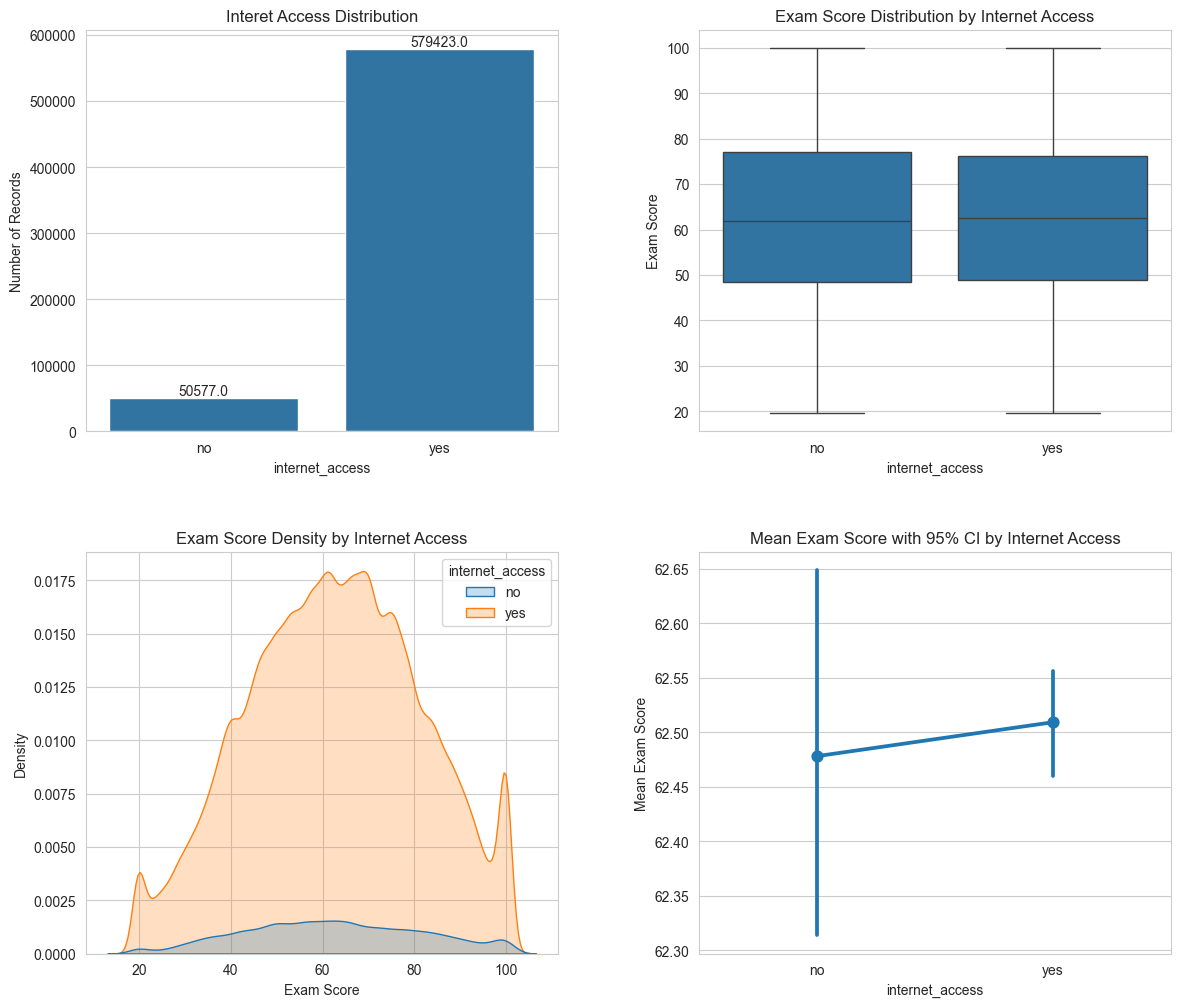

In [16]:
fig, ax = plt.subplots(2, 2, figsize=(14, 12))
ax = ax.flatten()

sns.countplot(x="internet_access", data=dataset_train, ax=ax[0])
for p in ax[0].patches:
    ax[0].annotate(f"{p.get_height()}", 
                 (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha="center", va="bottom")
ax[0].set_title("Interet Access Distribution")
ax[0].set_ylabel("Number of Records")

sns.boxplot(x="internet_access", y="exam_score", data=dataset_train, ax=ax[1])
ax[1].set_title("Exam Score Distribution by Internet Access")
ax[1].set_ylabel("Exam Score")

sns.kdeplot(data=dataset_train, x="exam_score", hue="internet_access", fill=True, ax=ax[2])
ax[2].set_title("Exam Score Density by Internet Access")
ax[2].set_xlabel("Exam Score")

sns.pointplot(x="internet_access", y="exam_score", data=dataset_train, ci=95, ax=ax[3])
ax[3].set_title("Mean Exam Score with 95% CI by Internet Access")
ax[3].set_ylabel("Mean Exam Score")


plt.subplots_adjust(hspace=0.3, wspace=0.3)
plt.show()

**1.1.2.9 - Analysis of sleep hours**

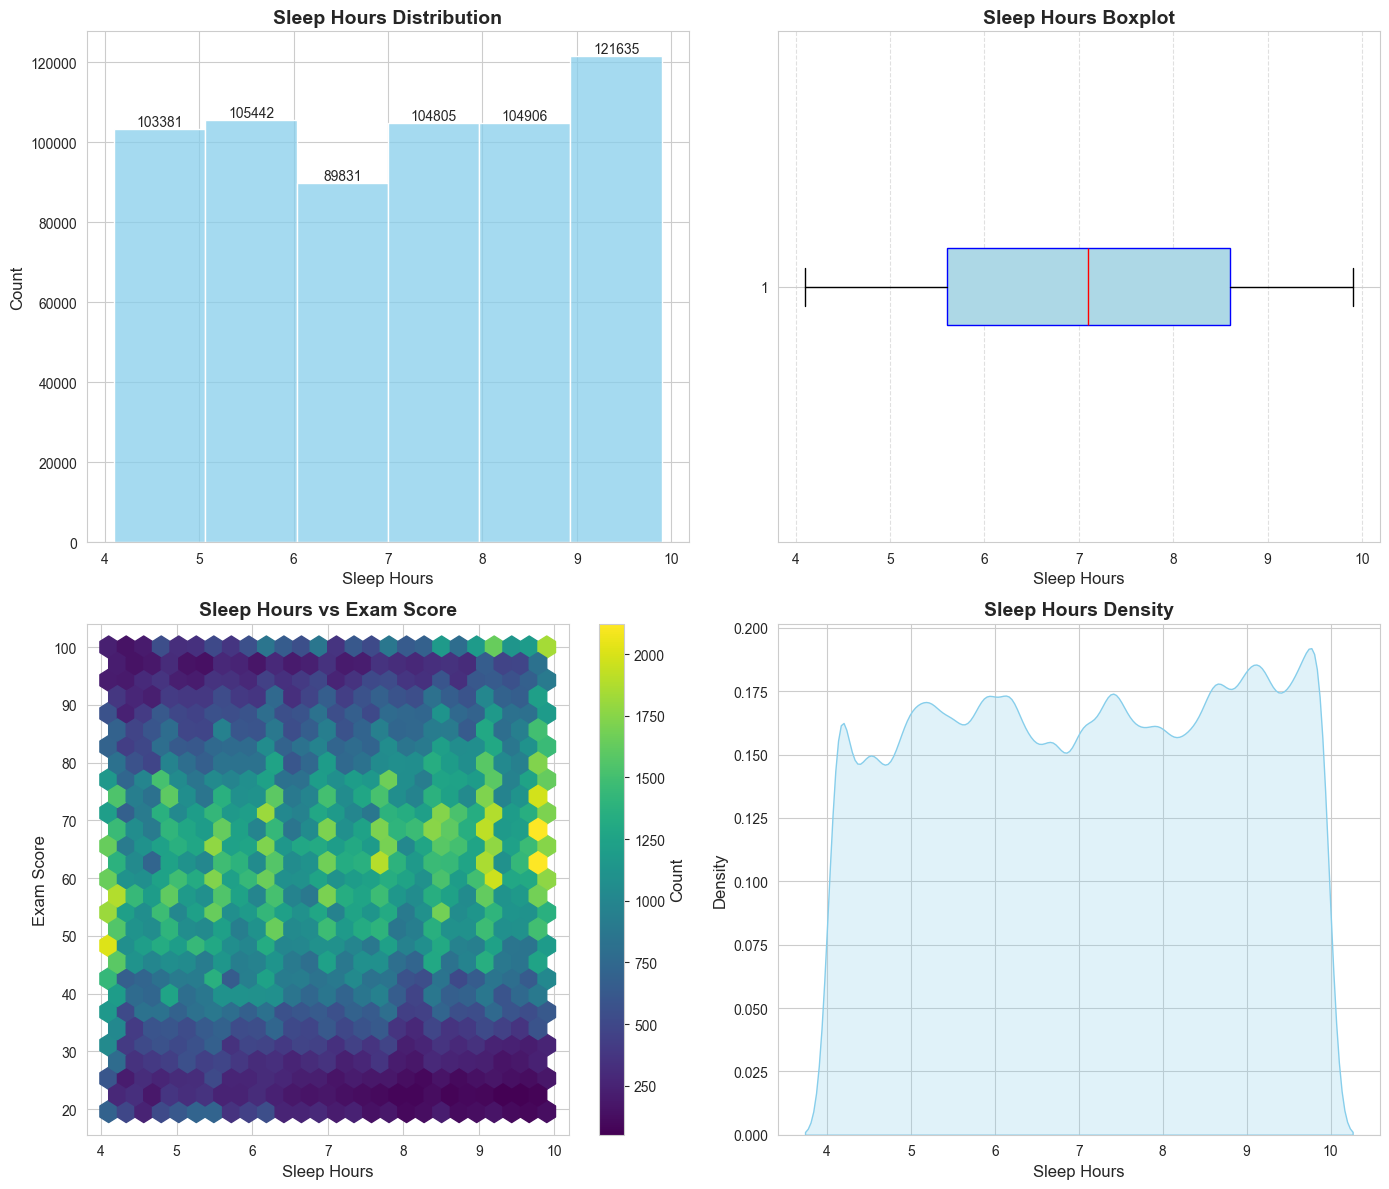

In [17]:
fig, ax = plt.subplots(2, 2, figsize=(14, 12))
ax = ax.flatten()


sns.histplot(dataset_train["sleep_hours"], bins=6, kde=False, ax=ax[0], color="skyblue")
ax[0].set_title("Sleep Hours Distribution", fontsize=14, fontweight='bold')
ax[0].set_xlabel("Sleep Hours", fontsize=12)
ax[0].set_ylabel("Count", fontsize=12)


for p in ax[0].patches:
    ax[0].annotate(f'{int(p.get_height())}',  
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha='center', va='bottom', fontsize=10)


ax[1].boxplot(dataset_train["sleep_hours"], vert=False, patch_artist=True,
              boxprops=dict(facecolor='lightblue', color='blue'),
              medianprops=dict(color='red'))
ax[1].grid(axis='x', linestyle='--', alpha=0.6)
ax[1].set_xlabel("Sleep Hours", fontsize=12)
ax[1].set_title("Sleep Hours Boxplot", fontsize=14, fontweight='bold')


hb = ax[2].hexbin(
    dataset_train["sleep_hours"],
    dataset_train["exam_score"],
    gridsize=25,
    cmap="viridis"
)
cbar = plt.colorbar(hb, ax=ax[2])
cbar.set_label("Count", fontsize=12)
ax[2].set_xlabel("Sleep Hours", fontsize=12)
ax[2].set_ylabel("Exam Score", fontsize=12)
ax[2].set_title("Sleep Hours vs Exam Score", fontsize=14, fontweight='bold')


sns.kdeplot(dataset_train["sleep_hours"], ax=ax[3], fill=True, color='skyblue')
ax[3].set_xlabel("Sleep Hours", fontsize=12)
ax[3].set_ylabel("Density", fontsize=12)
ax[3].set_title("Sleep Hours Density", fontsize=14, fontweight='bold')


plt.tight_layout()
plt.show()


**1.1.2.10 - Analysis of sleep quality column**

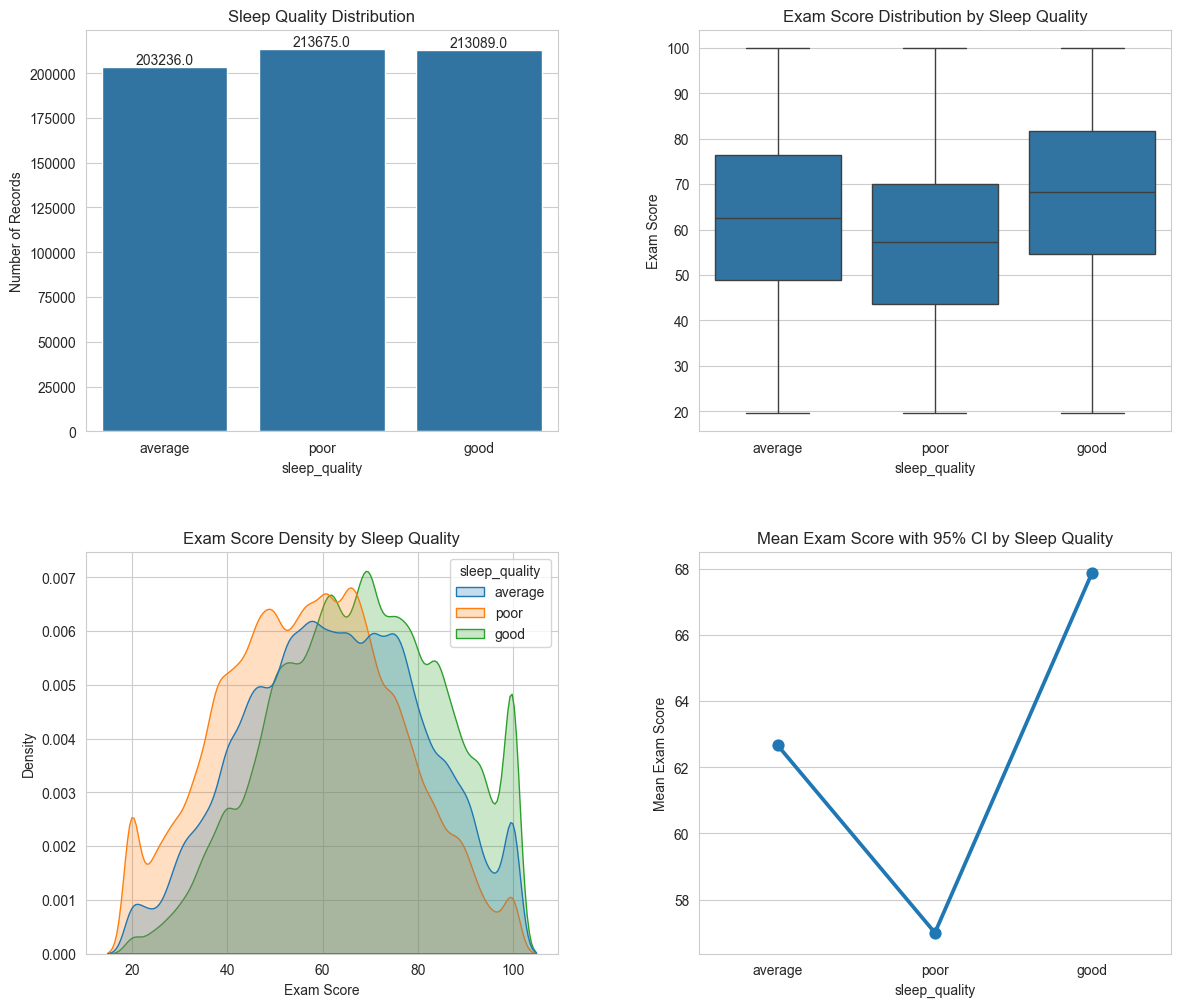

In [18]:
fig, ax = plt.subplots(2, 2, figsize=(14, 12))
ax = ax.flatten()

sns.countplot(x="sleep_quality", data=dataset_train, ax=ax[0])
for p in ax[0].patches:
    ax[0].annotate(f"{p.get_height()}", 
                 (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha="center", va="bottom")
ax[0].set_title("Sleep Quality Distribution")
ax[0].set_ylabel("Number of Records")

sns.boxplot(x="sleep_quality", y="exam_score", data=dataset_train, ax=ax[1])
ax[1].set_title("Exam Score Distribution by Sleep Quality")
ax[1].set_ylabel("Exam Score")

sns.kdeplot(data=dataset_train, x="exam_score", hue="sleep_quality", fill=True, ax=ax[2])
ax[2].set_title("Exam Score Density by Sleep Quality")
ax[2].set_xlabel("Exam Score")

sns.pointplot(x="sleep_quality", y="exam_score", data=dataset_train, ci=95, ax=ax[3])
ax[3].set_title("Mean Exam Score with 95% CI by Sleep Quality")
ax[3].set_ylabel("Mean Exam Score")


plt.subplots_adjust(hspace=0.3, wspace=0.3)
plt.show()

**1.1.2.11 - Analysis of study method column**

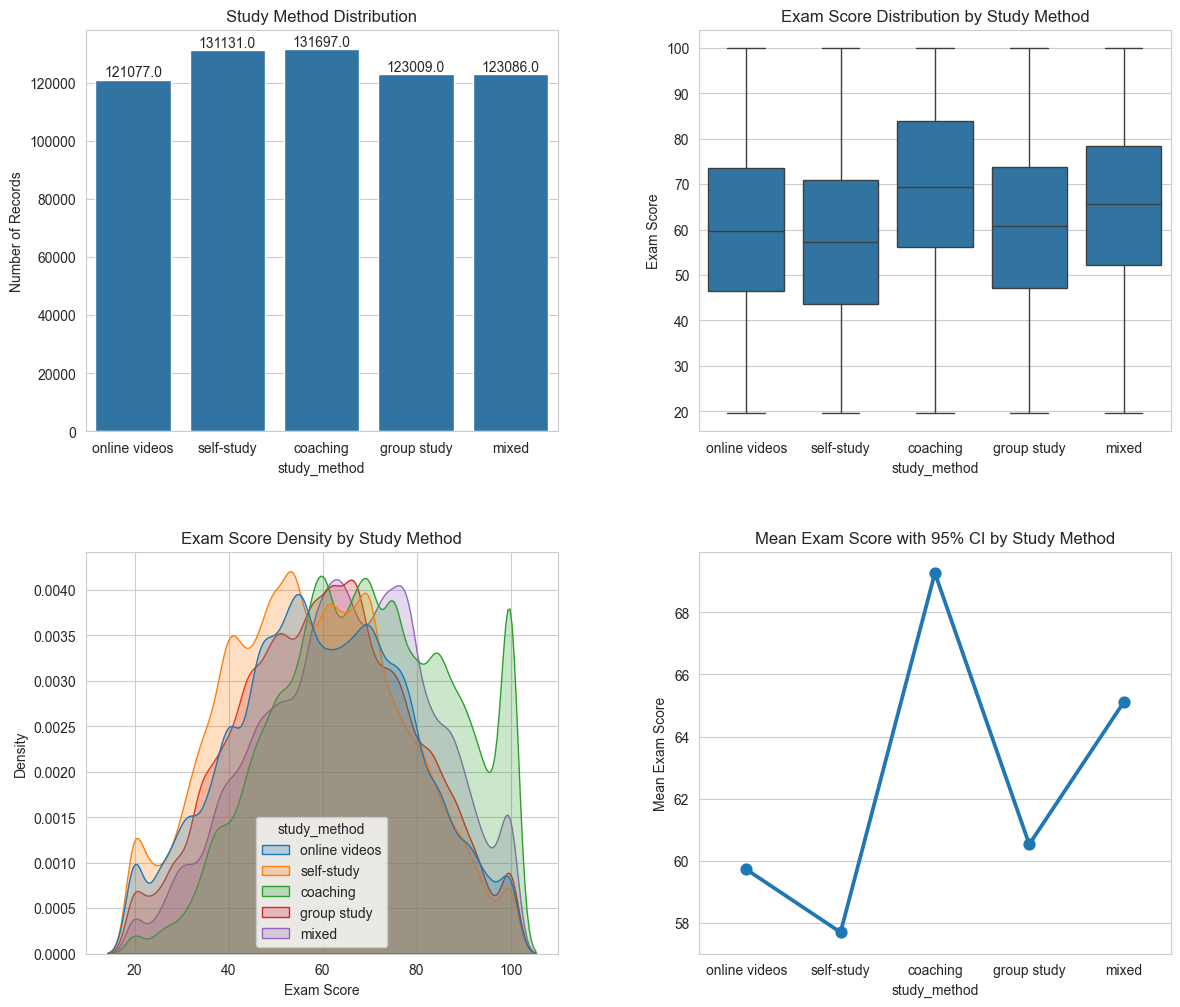

In [19]:
fig, ax = plt.subplots(2, 2, figsize=(14, 12))
ax = ax.flatten()

sns.countplot(x="study_method", data=dataset_train, ax=ax[0])
for p in ax[0].patches:
    ax[0].annotate(f"{p.get_height()}", 
                 (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha="center", va="bottom")
ax[0].set_title("Study Method Distribution")
ax[0].set_ylabel("Number of Records")

sns.boxplot(x="study_method", y="exam_score", data=dataset_train, ax=ax[1])
ax[1].set_title("Exam Score Distribution by Study Method")
ax[1].set_ylabel("Exam Score")

sns.kdeplot(data=dataset_train, x="exam_score", hue="study_method", fill=True, ax=ax[2])
ax[2].set_title("Exam Score Density by Study Method")
ax[2].set_xlabel("Exam Score")

sns.pointplot(x="study_method", y="exam_score", data=dataset_train, ci=95, ax=ax[3])
ax[3].set_title("Mean Exam Score with 95% CI by Study Method")
ax[3].set_ylabel("Mean Exam Score")


plt.subplots_adjust(hspace=0.3, wspace=0.3)
plt.show()

**1.1.2.12 - Analysis of facility rating column**

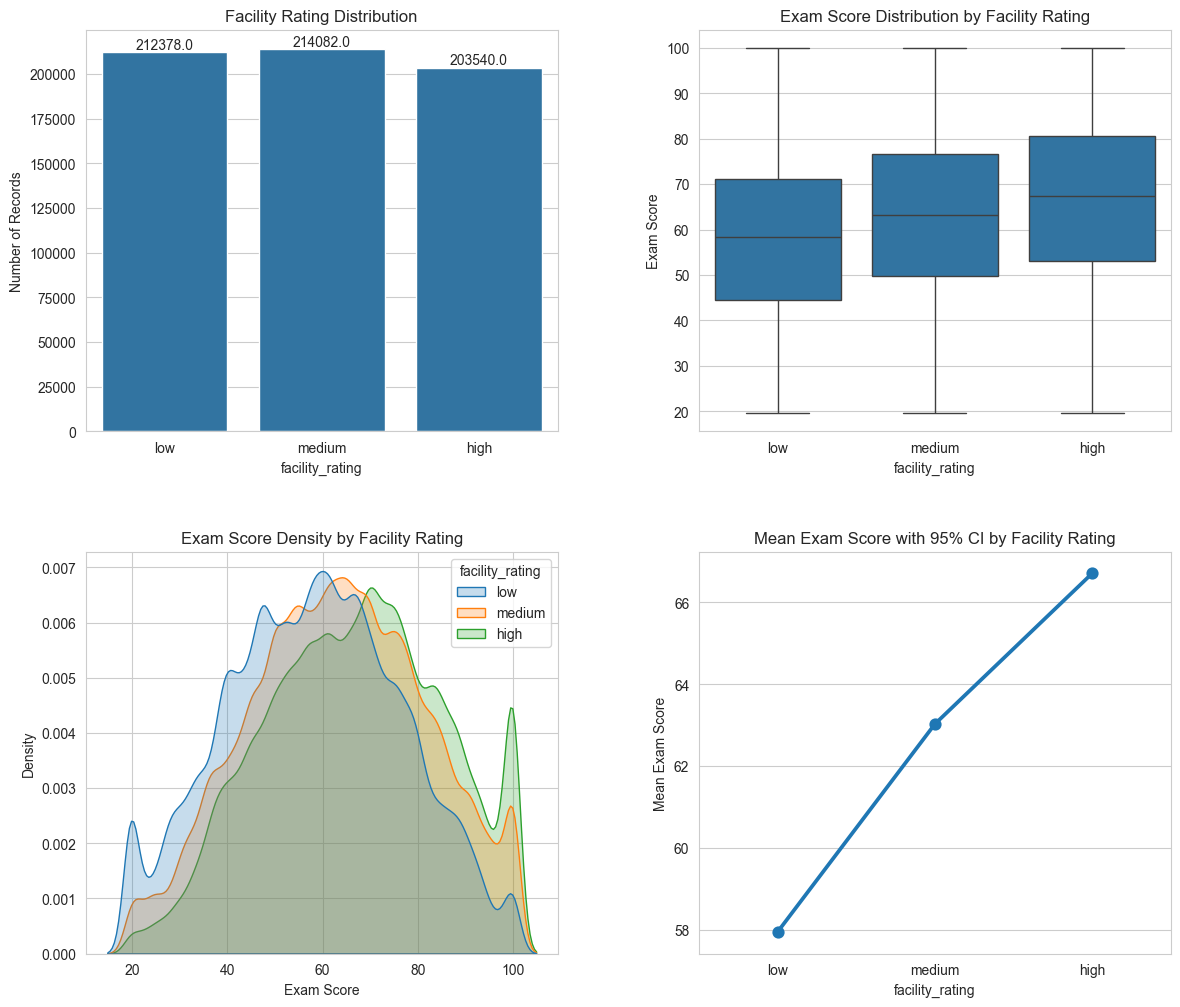

In [20]:
fig, ax = plt.subplots(2, 2, figsize=(14, 12))
ax = ax.flatten()

sns.countplot(x="facility_rating", data=dataset_train, ax=ax[0])
for p in ax[0].patches:
    ax[0].annotate(f"{p.get_height()}", 
                 (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha="center", va="bottom")
ax[0].set_title("Facility Rating Distribution")
ax[0].set_ylabel("Number of Records")

sns.boxplot(x="facility_rating", y="exam_score", data=dataset_train, ax=ax[1])
ax[1].set_title("Exam Score Distribution by Facility Rating")
ax[1].set_ylabel("Exam Score")

sns.kdeplot(data=dataset_train, x="exam_score", hue="facility_rating", fill=True, ax=ax[2])
ax[2].set_title("Exam Score Density by Facility Rating")
ax[2].set_xlabel("Exam Score")

sns.pointplot(x="facility_rating", y="exam_score", data=dataset_train, ci=95, ax=ax[3])
ax[3].set_title("Mean Exam Score with 95% CI by Facility Rating")
ax[3].set_ylabel("Mean Exam Score")


plt.subplots_adjust(hspace=0.3, wspace=0.3)
plt.show()

**1.1.2.13 - Analysis of exam difficulty column**

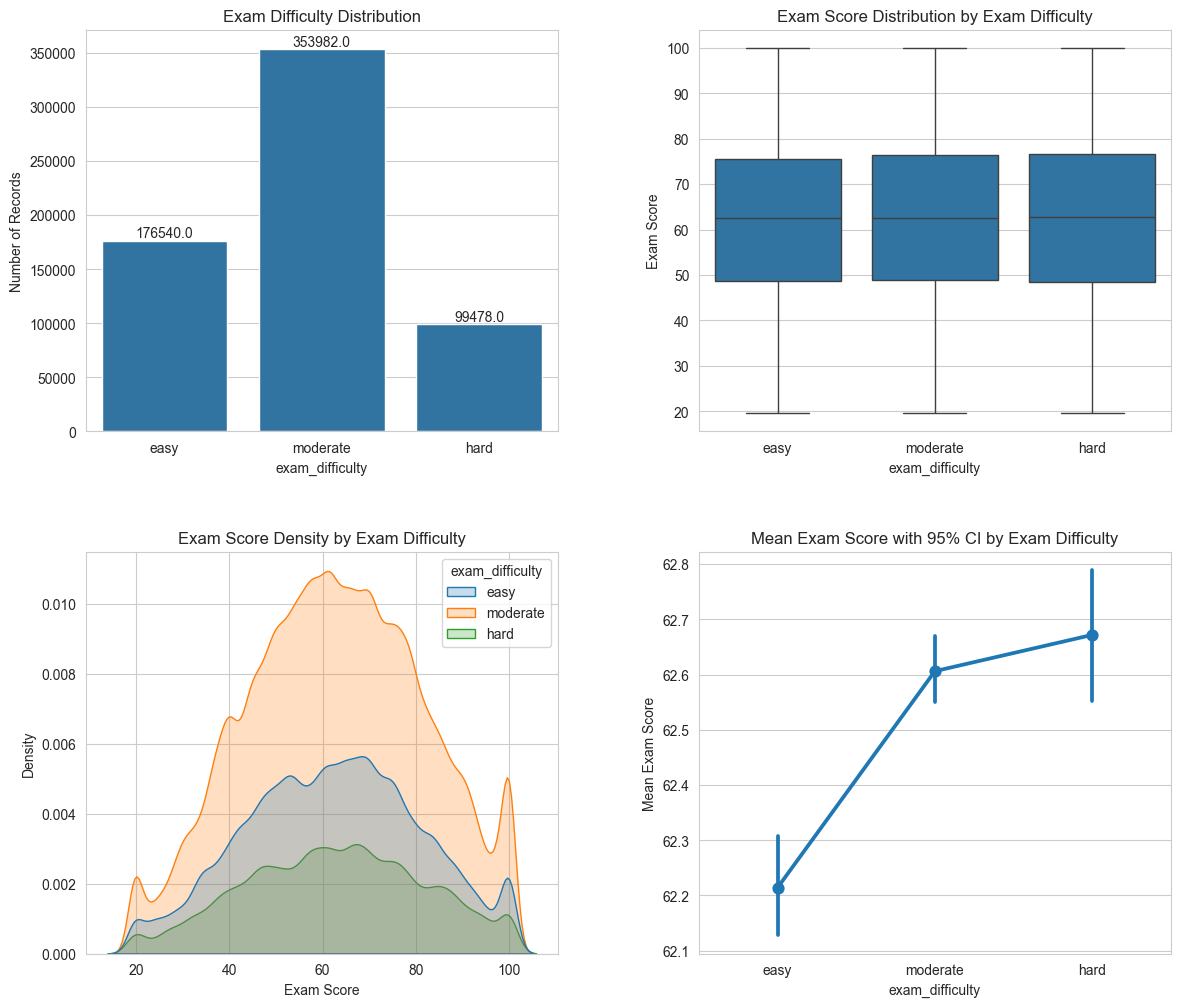

In [21]:
fig, ax = plt.subplots(2, 2, figsize=(14, 12))
ax = ax.flatten()

sns.countplot(x="exam_difficulty", data=dataset_train, ax=ax[0])
for p in ax[0].patches:
    ax[0].annotate(f"{p.get_height()}", 
                 (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha="center", va="bottom")
ax[0].set_title("Exam Difficulty Distribution")
ax[0].set_ylabel("Number of Records")

sns.boxplot(x="exam_difficulty", y="exam_score", data=dataset_train, ax=ax[1])
ax[1].set_title("Exam Score Distribution by Exam Difficulty")
ax[1].set_ylabel("Exam Score")

sns.kdeplot(data=dataset_train, x="exam_score", hue="exam_difficulty", fill=True, ax=ax[2])
ax[2].set_title("Exam Score Density by Exam Difficulty")
ax[2].set_xlabel("Exam Score")

sns.pointplot(x="exam_difficulty", y="exam_score", data=dataset_train, ci=95, ax=ax[3])
ax[3].set_title("Mean Exam Score with 95% CI by Exam Difficulty")
ax[3].set_ylabel("Mean Exam Score")


plt.subplots_adjust(hspace=0.3, wspace=0.3)
plt.show()

**1.1.2.14 - Correlation Heatmap**

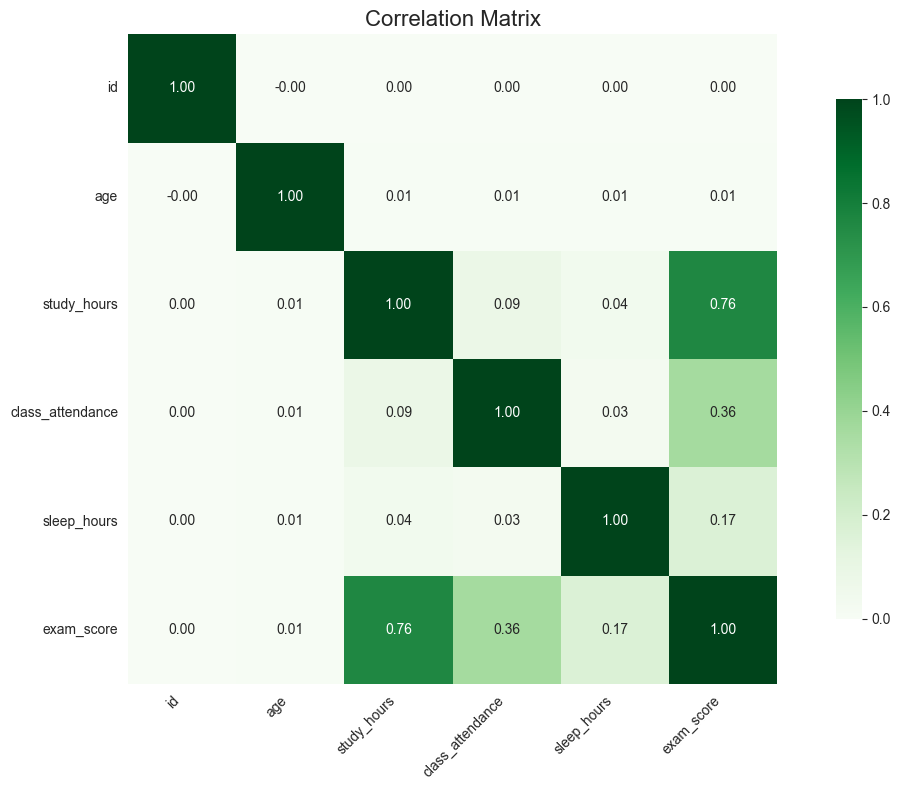

In [22]:
plt.figure(figsize=(12, 8)) 

sns.heatmap(
    dataset_train.corr(numeric_only=True),
    cmap="Greens",
    annot=True,
    fmt=".2f",       
    square=True,      
    cbar_kws={"shrink": 0.8} 
)

plt.title("Correlation Matrix", fontsize=16) 
plt.xticks(rotation=45, ha="right")           
plt.yticks(rotation=0)                        
plt.tight_layout()
plt.show()

**1.2 Test Dataset - EDA**

**1.2.1. Understanding the data**

In [23]:
dataset_test.head()

,id,age,gender,course,study_hours,class_attendance,internet_access,sleep_hours,sleep_quality,study_method,facility_rating,exam_difficulty
0,630000,24,other,ba,6.85,65.2,yes,5.2,poor,group study,high,easy
1,630001,18,male,diploma,6.61,45.0,no,9.3,poor,coaching,low,easy
2,630002,24,female,b.tech,6.60,98.5,yes,6.2,good,group study,medium,moderate
3,630003,24,male,diploma,3.03,66.3,yes,5.7,average,mixed,medium,moderate
4,630004,20,female,b.tech,2.03,42.4,yes,9.2,average,coaching,low,moderate


In [24]:
dataset_test.info()  

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 270000 entries, 0 to 269999
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   id                270000 non-null  int64  
 1   age               270000 non-null  int64  
 2   gender            270000 non-null  object 
 3   course            270000 non-null  object 
 4   study_hours       270000 non-null  float64
 5   class_attendance  270000 non-null  float64
 6   internet_access   270000 non-null  object 
 7   sleep_hours       270000 non-null  float64
 8   sleep_quality     270000 non-null  object 
 9   study_method      270000 non-null  object 
 10  facility_rating   270000 non-null  object 
 11  exam_difficulty   270000 non-null  object 
dtypes: float64(3), int64(2), object(7)
memory usage: 24.7+ MB


In [25]:
dataset_test.describe()  

,id,age,study_hours,class_attendance,sleep_hours
count,270000.000000,270000.000000,270000.000000,270000.000000,270000.000000
mean,764999.500000,20.544137,4.003878,71.982509,7.072070
std,77942.430678,2.260452,2.357741,17.414695,1.745513
min,630000.000000,17.000000,0.080000,40.600000,4.100000
25%,697499.750000,19.000000,1.980000,57.000000,5.600000
50%,764999.500000,21.000000,4.010000,72.600000,7.100000
75%,832499.250000,23.000000,6.050000,87.200000,8.600000
max,899999.000000,24.000000,7.910000,99.400000,9.900000


In [26]:
dataset_test.nunique()

id                  270000
age                      8
gender                   3
course                   7
study_hours            786
class_attendance       604
internet_access          2
sleep_hours             64
sleep_quality            3
study_method             5
facility_rating          3
exam_difficulty          3
dtype: int64

**1.2.2 Data Visualization**

**1.2.2.1 Features**

**1.2.2.2 - Analysis of the age column**

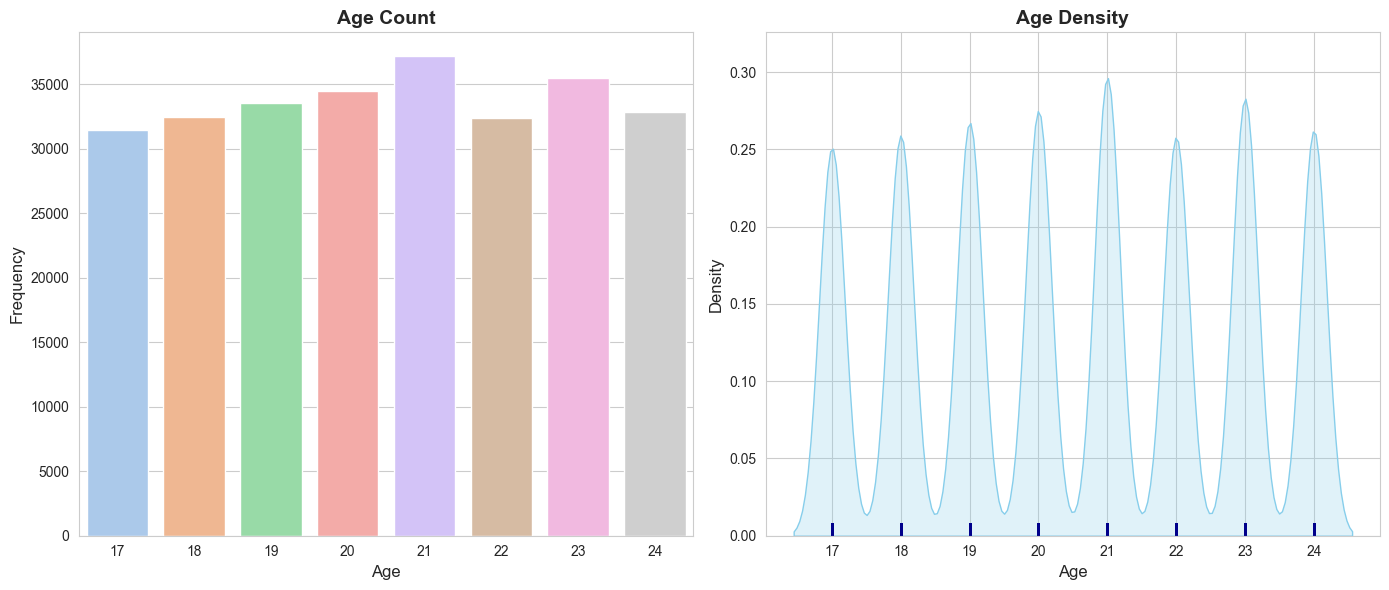

In [27]:
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
ax = ax.flatten()


sns.countplot(x="age", data=dataset_test, ax=ax[0], palette=palette)
ax[0].set_title("Age Count", fontsize=14, fontweight="bold")
ax[0].set_xlabel("Age", fontsize=12)
ax[0].set_ylabel("Frequency", fontsize=12)


sns.kdeplot(dataset_test["age"], ax=ax[1], fill=True, color="skyblue")
sns.rugplot(dataset_test["age"], ax=ax[1], color="darkblue")
ax[1].set_xlabel("Age", fontsize=12)
ax[1].set_ylabel("Density", fontsize=12)
ax[1].set_title("Age Density", fontsize=14, fontweight="bold")


plt.tight_layout()
plt.show()


**1.2.2.3 - Analysis of the gender column**

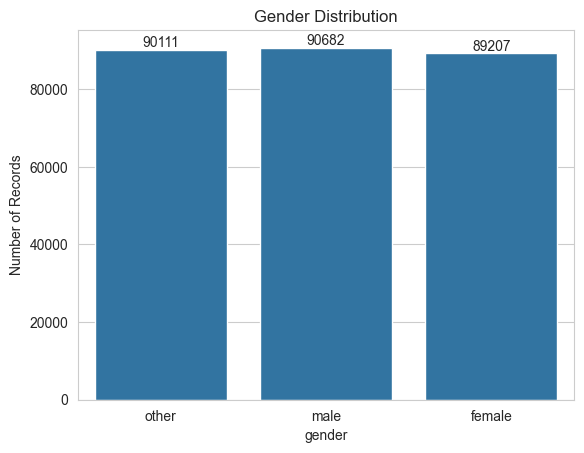

In [28]:
ax = sns.countplot(x="gender", data=dataset_test)

for p in ax.patches:
    ax.annotate(f"{int(p.get_height())}",
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha="center", va="bottom")

ax.set_title("Gender Distribution")
ax.set_ylabel("Number of Records")

plt.show()

**1.2.2.4 - Analysis of the course column**

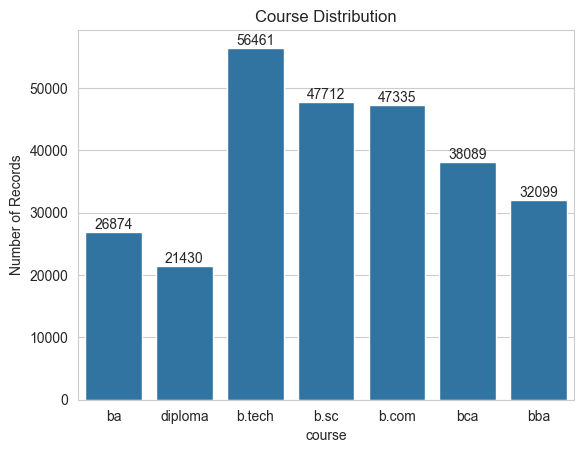

In [29]:
ax = sns.countplot(x="course", data=dataset_test)

for p in ax.patches:
    ax.annotate(f"{int(p.get_height())}",
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha="center", va="bottom")

ax.set_title("Course Distribution")
ax.set_ylabel("Number of Records")

plt.show()

**1.2.2.5 - Analysis of the study hours column**

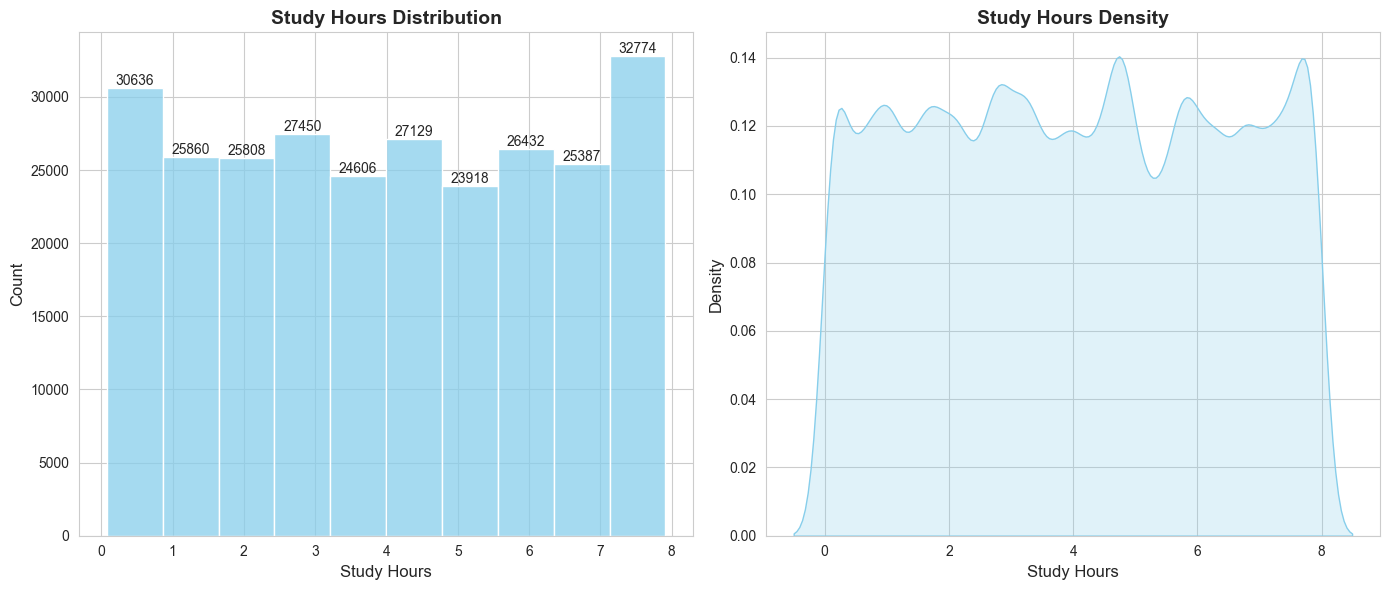

In [30]:
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
ax = ax.flatten()


sns.histplot(dataset_test["study_hours"], bins=10, kde=False, ax=ax[0], color="skyblue")
ax[0].set_title("Study Hours Distribution", fontsize=14, fontweight="bold")
ax[0].set_xlabel("Study Hours", fontsize=12)
ax[0].set_ylabel("Count", fontsize=12)


for p in ax[0].patches:
    ax[0].annotate(f"{int(p.get_height())}",  
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha="center", va="bottom", fontsize=10)


sns.kdeplot(dataset_test["study_hours"], ax=ax[1], fill=True, color="skyblue")
ax[1].set_xlabel("Study Hours", fontsize=12)
ax[1].set_ylabel("Density", fontsize=12)
ax[1].set_title("Study Hours Density", fontsize=14, fontweight="bold")


plt.tight_layout()
plt.show()


**1.2.2.6 - Analysis of the class attendance column**

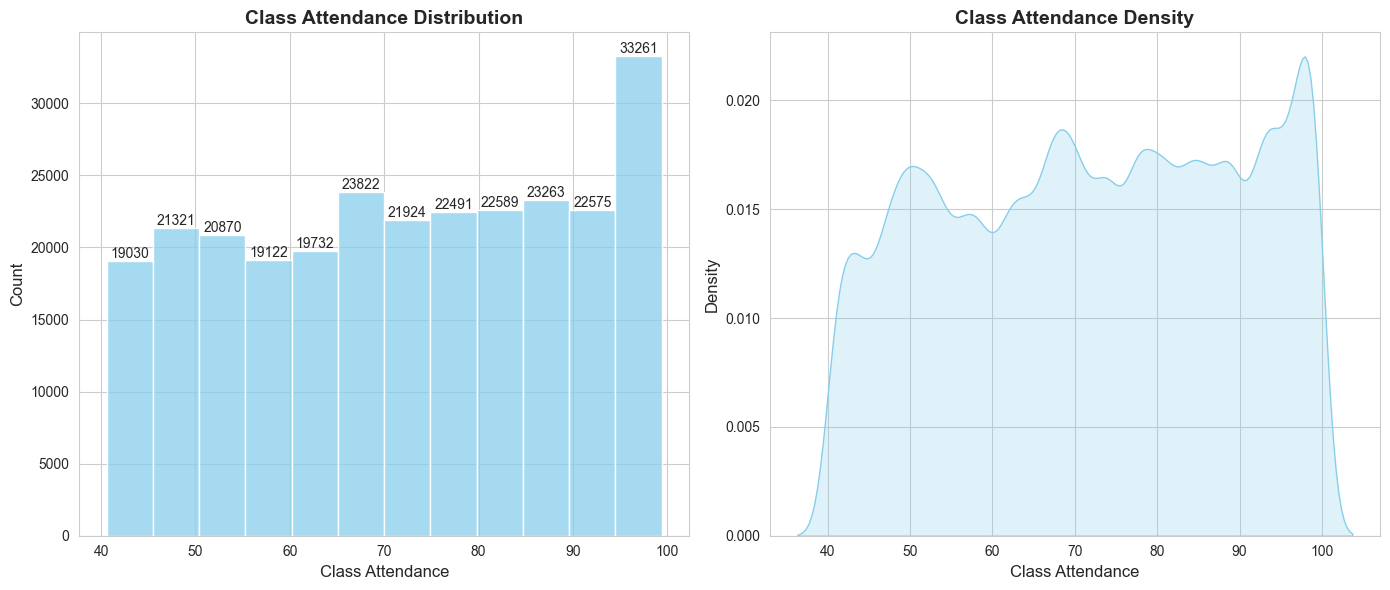

In [31]:
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
ax = ax.flatten()


sns.histplot(dataset_test["class_attendance"], binwidth=5, kde=False, ax=ax[0], color="skyblue")
ax[0].set_title("Class Attendance Distribution", fontsize=14, fontweight="bold")
ax[0].set_xlabel("Class Attendance", fontsize=12)
ax[0].set_ylabel("Count", fontsize=12)

for p in ax[0].patches:
    ax[0].annotate(f"{int(p.get_height())}",  
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha="center", va="bottom", fontsize=10)


sns.kdeplot(dataset_test["class_attendance"], ax=ax[1], fill=True, color="skyblue")
ax[1].set_xlabel("Class Attendance", fontsize=12)
ax[1].set_ylabel("Density", fontsize=12)
ax[1].set_title("Class Attendance Density", fontsize=14, fontweight="bold")


plt.tight_layout()
plt.show()


**1.2.2.7 - Analysis of the internet access column**

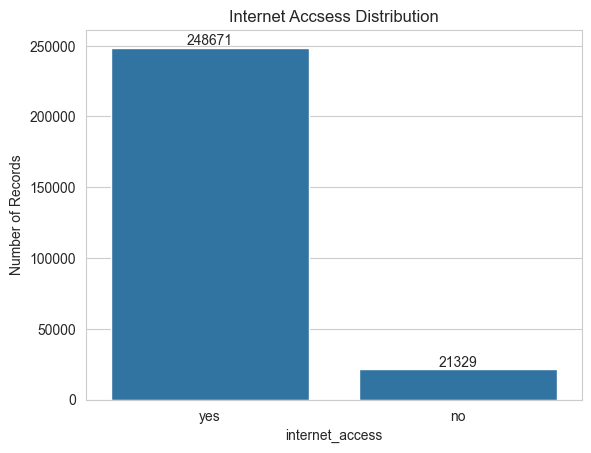

In [32]:
ax = sns.countplot(x="internet_access", data=dataset_test)

for p in ax.patches:
    ax.annotate(f"{int(p.get_height())}",
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha="center", va="bottom")

ax.set_title("Internet Accsess Distribution")
ax.set_ylabel("Number of Records")

plt.show()

**1.2.2.8 - Analysis of the sleep hours column**

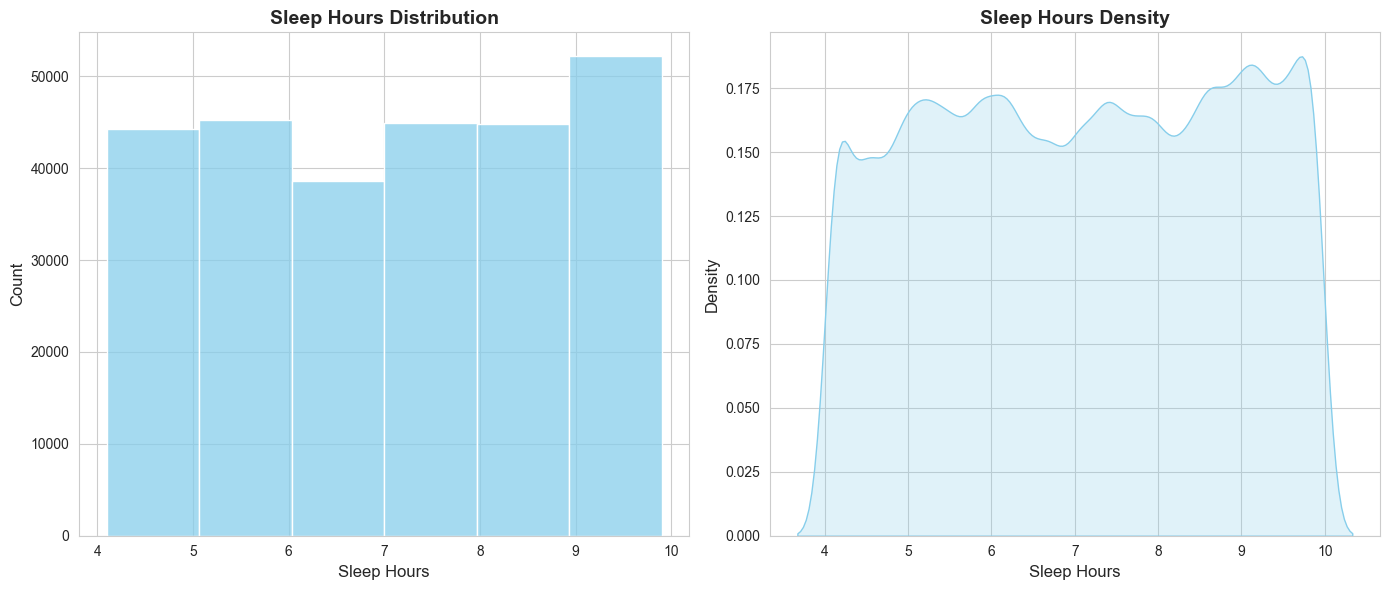

In [33]:
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
ax = ax.flatten()

sns.histplot(dataset_test["sleep_hours"], bins=6, kde=False, ax=ax[0], color="skyblue")
ax[0].set_title("Sleep Hours Distribution", fontsize=14, fontweight="bold")
ax[0].set_xlabel("Sleep Hours", fontsize=12)
ax[0].set_ylabel("Count", fontsize=12)


sns.kdeplot(dataset_test["sleep_hours"], ax=ax[1], fill=True, color="skyblue")
ax[1].set_xlabel("Sleep Hours", fontsize=12)
ax[1].set_ylabel("Density", fontsize=12)
ax[1].set_title("Sleep Hours Density", fontsize=14, fontweight="bold")


plt.tight_layout()
plt.show()


**1.2.2.9 - Analysis of the sleep quality column**

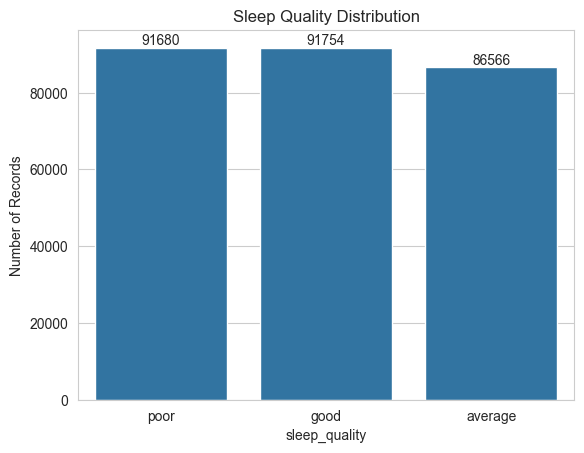

In [34]:
ax = sns.countplot(x="sleep_quality", data=dataset_test)

for p in ax.patches:
    ax.annotate(f"{int(p.get_height())}",
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha="center", va="bottom")

ax.set_title("Sleep Quality Distribution")
ax.set_ylabel("Number of Records")

plt.show()

**1.2.2.10 - Analysis of the study method column**

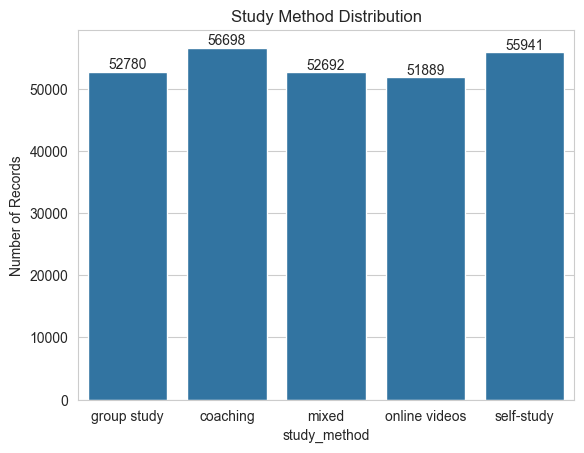

In [35]:
ax = sns.countplot(x="study_method", data=dataset_test)

for p in ax.patches:
    ax.annotate(f"{int(p.get_height())}",
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha="center", va="bottom")

ax.set_title("Study Method Distribution")
ax.set_ylabel("Number of Records")

plt.show()

**1.2.2.11 - Analysis of the facility rating column**

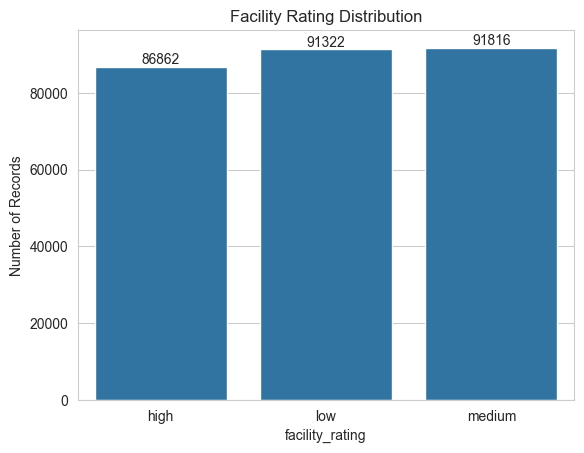

In [36]:
ax = sns.countplot(x="facility_rating", data=dataset_test)

for p in ax.patches:
    ax.annotate(f"{int(p.get_height())}",
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha="center", va="bottom")

ax.set_title("Facility Rating Distribution")
ax.set_ylabel("Number of Records")

plt.show()

**1.2.2.12 - Analysis of the exam difficulty column**

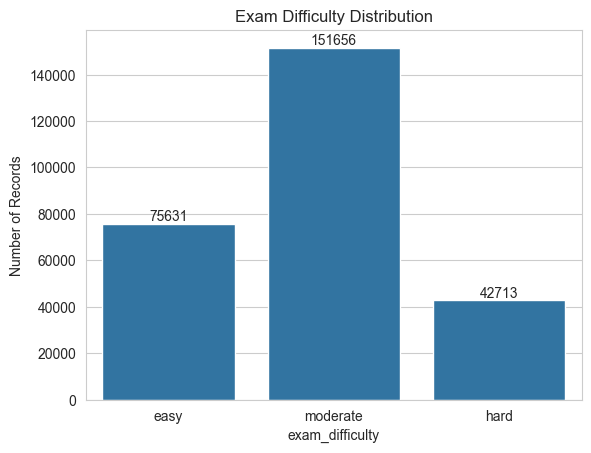

In [37]:
ax = sns.countplot(x="exam_difficulty", data=dataset_test)

for p in ax.patches:
    ax.annotate(f"{int(p.get_height())}",
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha="center", va="bottom")

ax.set_title("Exam Difficulty Distribution")
ax.set_ylabel("Number of Records")

plt.show()

### 2. Data Cleaning

**2.1 Check and remove duplicates**

In [38]:
dataset_train.duplicated().sum()

np.int64(0)

In [39]:
dataset_test.duplicated().sum()

np.int64(0)

There are no duplicates to remove in either the training or the test dataset.

**2.2 Detect missing values**

In [40]:
dataset_train.isnull().sum()

id                  0
age                 0
gender              0
course              0
study_hours         0
class_attendance    0
internet_access     0
sleep_hours         0
sleep_quality       0
study_method        0
facility_rating     0
exam_difficulty     0
exam_score          0
dtype: int64

In [41]:
dataset_test.isnull().sum()

id                  0
age                 0
gender              0
course              0
study_hours         0
class_attendance    0
internet_access     0
sleep_hours         0
sleep_quality       0
study_method        0
facility_rating     0
exam_difficulty     0
dtype: int64

There are no missing values to handle in either the training or the test dataset.

**2.3 Droping Irrelavant Columns**

The ID column was removed since it does not provide any predictive value for the model.

In [42]:
dataset_train = dataset_train.drop(["id"], axis= 1)

In [43]:
dataset_train

,age,gender,course,study_hours,class_attendance,internet_access,sleep_hours,sleep_quality,study_method,facility_rating,exam_difficulty,exam_score
0,21,female,b.sc,7.91,98.8,no,4.9,average,online videos,low,easy,78.300
1,18,other,diploma,4.95,94.8,yes,4.7,poor,self-study,medium,moderate,46.700
2,20,female,b.sc,4.68,92.6,yes,5.8,poor,coaching,high,moderate,99.000
3,19,male,b.sc,2.00,49.5,yes,8.3,average,group study,high,moderate,63.900
4,23,male,bca,7.65,86.9,yes,9.6,good,self-study,high,easy,100.000
...,...,...,...,...,...,...,...,...,...,...,...,...
629995,18,female,b.tech,4.86,70.7,yes,4.1,good,mixed,high,moderate,69.500
629996,21,female,ba,7.08,54.4,yes,4.5,average,mixed,low,moderate,78.900
629997,24,male,bca,0.64,44.2,yes,4.3,poor,online videos,low,moderate,19.599
629998,20,male,b.com,1.54,75.1,yes,8.2,average,group study,high,moderate,59.100


In [44]:
pass_col = dataset_test["id"]

In [45]:
dataset_test = dataset_test.drop(["id"], axis= 1)

In [46]:
dataset_test

,age,gender,course,study_hours,class_attendance,internet_access,sleep_hours,sleep_quality,study_method,facility_rating,exam_difficulty
0,24,other,ba,6.85,65.2,yes,5.2,poor,group study,high,easy
1,18,male,diploma,6.61,45.0,no,9.3,poor,coaching,low,easy
2,24,female,b.tech,6.60,98.5,yes,6.2,good,group study,medium,moderate
3,24,male,diploma,3.03,66.3,yes,5.7,average,mixed,medium,moderate
4,20,female,b.tech,2.03,42.4,yes,9.2,average,coaching,low,moderate
...,...,...,...,...,...,...,...,...,...,...,...
269995,21,other,b.com,2.55,82.3,yes,8.4,average,mixed,medium,hard
269996,17,female,b.com,0.49,46.4,yes,8.8,good,mixed,low,easy
269997,22,male,bba,6.62,74.7,yes,5.5,good,coaching,high,easy
269998,22,other,ba,4.08,51.8,yes,8.7,poor,online videos,high,moderate


### 3. Feature Engineering

**3.1 Binary Encoding**

The Internet access feature consists of two categories (yes and no). In the preprocessing stage, it will be transformed into a binary variable, where yes was encoded as 1 and no as 0.

In [47]:
dataset_train["internet_access"].nunique()

2

In [48]:
dataset_test["internet_access"].nunique()

2

In [ ]:
dataset_train["internet_access"] = dataset_train["internet_access"].replace({"yes": 1, "no": 0})
dataset_test["internet_access"] = dataset_test["internet_access"].replace({"yes": 1, "no": 0})

In [50]:
dataset_train

,age,gender,course,study_hours,class_attendance,internet_access,sleep_hours,sleep_quality,study_method,facility_rating,exam_difficulty,exam_score
0,21,female,b.sc,7.91,98.8,0,4.9,average,online videos,low,easy,78.300
1,18,other,diploma,4.95,94.8,1,4.7,poor,self-study,medium,moderate,46.700
2,20,female,b.sc,4.68,92.6,1,5.8,poor,coaching,high,moderate,99.000
3,19,male,b.sc,2.00,49.5,1,8.3,average,group study,high,moderate,63.900
4,23,male,bca,7.65,86.9,1,9.6,good,self-study,high,easy,100.000
...,...,...,...,...,...,...,...,...,...,...,...,...
629995,18,female,b.tech,4.86,70.7,1,4.1,good,mixed,high,moderate,69.500
629996,21,female,ba,7.08,54.4,1,4.5,average,mixed,low,moderate,78.900
629997,24,male,bca,0.64,44.2,1,4.3,poor,online videos,low,moderate,19.599
629998,20,male,b.com,1.54,75.1,1,8.2,average,group study,high,moderate,59.100


In [51]:
dataset_test

,age,gender,course,study_hours,class_attendance,internet_access,sleep_hours,sleep_quality,study_method,facility_rating,exam_difficulty
0,24,other,ba,6.85,65.2,1,5.2,poor,group study,high,easy
1,18,male,diploma,6.61,45.0,0,9.3,poor,coaching,low,easy
2,24,female,b.tech,6.60,98.5,1,6.2,good,group study,medium,moderate
3,24,male,diploma,3.03,66.3,1,5.7,average,mixed,medium,moderate
4,20,female,b.tech,2.03,42.4,1,9.2,average,coaching,low,moderate
...,...,...,...,...,...,...,...,...,...,...,...
269995,21,other,b.com,2.55,82.3,1,8.4,average,mixed,medium,hard
269996,17,female,b.com,0.49,46.4,1,8.8,good,mixed,low,easy
269997,22,male,bba,6.62,74.7,1,5.5,good,coaching,high,easy
269998,22,other,ba,4.08,51.8,1,8.7,poor,online videos,high,moderate


**3.2 Ordinal Encoding**

There are three columns that should be ordinally encoded: sleep_quality, facility_rating, and exam_difficulty.

In [52]:
dataset_train["sleep_quality"].value_counts()

sleep_quality
poor       213675
good       213089
average    203236
Name: count, dtype: int64

In [53]:
dataset_train["facility_rating"].value_counts()

facility_rating
medium    214082
low       212378
high      203540
Name: count, dtype: int64

In [54]:
dataset_train["exam_difficulty"].value_counts()

exam_difficulty
moderate    353982
easy        176540
hard         99478
Name: count, dtype: int64

In [55]:
ordinal_features = ["sleep_quality", "facility_rating", "exam_difficulty"]

categories = [
    ["poor", "average", "good"],      # sleep_quality
    ["low", "medium", "high"],        # facility_rating
    ["easy", "moderate", "hard"]      # exam_difficulty
]

In [56]:
ordinal_encoder = OrdinalEncoder(categories=categories)

**3.2.1 - Train dataset**

In [57]:
dataset_train[ordinal_features] = ordinal_encoder.fit_transform(dataset_train[ordinal_features])

In [58]:
dataset_train 

,age,gender,course,study_hours,class_attendance,internet_access,sleep_hours,sleep_quality,study_method,facility_rating,exam_difficulty,exam_score
0,21,female,b.sc,7.91,98.8,0,4.9,1.0,online videos,0.0,0.0,78.300
1,18,other,diploma,4.95,94.8,1,4.7,0.0,self-study,1.0,1.0,46.700
2,20,female,b.sc,4.68,92.6,1,5.8,0.0,coaching,2.0,1.0,99.000
3,19,male,b.sc,2.00,49.5,1,8.3,1.0,group study,2.0,1.0,63.900
4,23,male,bca,7.65,86.9,1,9.6,2.0,self-study,2.0,0.0,100.000
...,...,...,...,...,...,...,...,...,...,...,...,...
629995,18,female,b.tech,4.86,70.7,1,4.1,2.0,mixed,2.0,1.0,69.500
629996,21,female,ba,7.08,54.4,1,4.5,1.0,mixed,0.0,1.0,78.900
629997,24,male,bca,0.64,44.2,1,4.3,0.0,online videos,0.0,1.0,19.599
629998,20,male,b.com,1.54,75.1,1,8.2,1.0,group study,2.0,1.0,59.100


In [59]:
dataset_train["sleep_quality"].value_counts()

sleep_quality
0.0    213675
2.0    213089
1.0    203236
Name: count, dtype: int64

In [60]:
dataset_train["facility_rating"].value_counts()

facility_rating
1.0    214082
0.0    212378
2.0    203540
Name: count, dtype: int64

In [61]:
dataset_train["exam_difficulty"].value_counts()

exam_difficulty
1.0    353982
0.0    176540
2.0     99478
Name: count, dtype: int64

**3.2.2 - Test dataset**

In [62]:
dataset_test[ordinal_features] = ordinal_encoder.fit_transform(dataset_test[ordinal_features])

In [63]:
dataset_test

,age,gender,course,study_hours,class_attendance,internet_access,sleep_hours,sleep_quality,study_method,facility_rating,exam_difficulty
0,24,other,ba,6.85,65.2,1,5.2,0.0,group study,2.0,0.0
1,18,male,diploma,6.61,45.0,0,9.3,0.0,coaching,0.0,0.0
2,24,female,b.tech,6.60,98.5,1,6.2,2.0,group study,1.0,1.0
3,24,male,diploma,3.03,66.3,1,5.7,1.0,mixed,1.0,1.0
4,20,female,b.tech,2.03,42.4,1,9.2,1.0,coaching,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
269995,21,other,b.com,2.55,82.3,1,8.4,1.0,mixed,1.0,2.0
269996,17,female,b.com,0.49,46.4,1,8.8,2.0,mixed,0.0,0.0
269997,22,male,bba,6.62,74.7,1,5.5,2.0,coaching,2.0,0.0
269998,22,other,ba,4.08,51.8,1,8.7,0.0,online videos,2.0,1.0


In [64]:
dataset_test["sleep_quality"].value_counts()

sleep_quality
2.0    91754
0.0    91680
1.0    86566
Name: count, dtype: int64

In [65]:
dataset_test["facility_rating"].value_counts()

facility_rating
1.0    91816
0.0    91322
2.0    86862
Name: count, dtype: int64

In [66]:
dataset_test["exam_difficulty"].value_counts()

exam_difficulty
1.0    151656
0.0     75631
2.0     42713
Name: count, dtype: int64

**3.3 One-hot encoding**

There are three columns that should be one-hot encoded: gender, course, and study_method.

In [67]:
ordinal_features = ["gender", "course", "study_method"]

**3.3.1 - Train dataset**

In [68]:
dataset_train["gender"].value_counts()

gender
other     211097
male      210593
female    208310
Name: count, dtype: int64

In [69]:
dataset_train["course"].value_counts()

course
b.tech     131236
b.sc       111554
b.com      110932
bca         88721
bba         75644
ba          61989
diploma     49924
Name: count, dtype: int64

In [70]:
dataset_train["study_method"].value_counts()

study_method
coaching         131697
self-study       131131
mixed            123086
group study      123009
online videos    121077
Name: count, dtype: int64

In [71]:
ohe = OneHotEncoder(sparse_output=False, handle_unknown="ignore")
ohe_encoded = ohe.fit_transform(dataset_train[ordinal_features])
ohe_cols = ohe.get_feature_names_out(ordinal_features)
ohe_dataset = pd.DataFrame(ohe_encoded, columns=ohe_cols, index=dataset_train.index)

In [72]:
dataset_train = dataset_train.drop(ordinal_features, axis=1)
dataset_train = pd.concat([dataset_train, ohe_dataset], axis=1)

In [73]:
dataset_train

,age,study_hours,class_attendance,internet_access,sleep_hours,sleep_quality,facility_rating,exam_difficulty,exam_score,gender_female,...,course_b.tech,course_ba,course_bba,course_bca,course_diploma,study_method_coaching,study_method_group study,study_method_mixed,study_method_online videos,study_method_self-study
0,21,7.91,98.8,0,4.9,1.0,0.0,0.0,78.300,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,18,4.95,94.8,1,4.7,0.0,1.0,1.0,46.700,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,20,4.68,92.6,1,5.8,0.0,2.0,1.0,99.000,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,19,2.00,49.5,1,8.3,1.0,2.0,1.0,63.900,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,23,7.65,86.9,1,9.6,2.0,2.0,0.0,100.000,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
629995,18,4.86,70.7,1,4.1,2.0,2.0,1.0,69.500,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
629996,21,7.08,54.4,1,4.5,1.0,0.0,1.0,78.900,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
629997,24,0.64,44.2,1,4.3,0.0,0.0,1.0,19.599,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
629998,20,1.54,75.1,1,8.2,1.0,2.0,1.0,59.100,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


**3.3.2 - Test dataset**

In [74]:
dataset_test["gender"].value_counts()

gender
male      90682
other     90111
female    89207
Name: count, dtype: int64

In [75]:
dataset_test["course"].value_counts()

course
b.tech     56461
b.sc       47712
b.com      47335
bca        38089
bba        32099
ba         26874
diploma    21430
Name: count, dtype: int64

In [76]:
dataset_test["study_method"].value_counts()

study_method
coaching         56698
self-study       55941
group study      52780
mixed            52692
online videos    51889
Name: count, dtype: int64

In [77]:
ohe_test = OneHotEncoder(sparse_output=False, handle_unknown="ignore")
ohe_encoded_test = ohe_test.fit_transform(dataset_test[ordinal_features])
ohe_cols_test = ohe_test.get_feature_names_out(ordinal_features)
ohe_dataset_test = pd.DataFrame(ohe_encoded_test, columns=ohe_cols_test, index=dataset_test.index)

In [78]:
dataset_test = dataset_test.drop(ordinal_features, axis=1)
dataset_test = pd.concat([dataset_test, ohe_dataset_test], axis=1)

In [79]:
dataset_test

,age,study_hours,class_attendance,internet_access,sleep_hours,sleep_quality,facility_rating,exam_difficulty,gender_female,gender_male,...,course_b.tech,course_ba,course_bba,course_bca,course_diploma,study_method_coaching,study_method_group study,study_method_mixed,study_method_online videos,study_method_self-study
0,24,6.85,65.2,1,5.2,0.0,2.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,18,6.61,45.0,0,9.3,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
2,24,6.60,98.5,1,6.2,2.0,1.0,1.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,24,3.03,66.3,1,5.7,1.0,1.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
4,20,2.03,42.4,1,9.2,1.0,0.0,1.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
269995,21,2.55,82.3,1,8.4,1.0,1.0,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
269996,17,0.49,46.4,1,8.8,2.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
269997,22,6.62,74.7,1,5.5,2.0,2.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
269998,22,4.08,51.8,1,8.7,0.0,2.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


**3.4 Feature Transformation**

Since this is a regression problem, numerical features with a wide range of values will be scaled using StandardScaler. StandardScaler is particularly suitable for this problem because:

- Linear models (Linear Regression, Ridge, Lasso, and Elastic Net) assume that features are centered, which improves numerical stability and interpretability.

- Regularization techniques (Ridge, Lasso, and Elastic Net) are sensitive to feature magnitudes, so scaling ensures consistent application of penalties across all features.

- Centering features around zero also facilitates faster convergence during gradient-based optimization, as the data becomes roughly symmetric around the origin.


The other algorithms (Decision Tree, Random Forest, XGBoost, and LightGBM) do not require feature scaling. However, since scaling does not negatively affect tree-based models, the dataset will initially be used in its scaled form.

In [80]:
scaler = StandardScaler()

**3.4.1 Train data**

In [81]:
cols_scaled = ["age", "study_hours", "class_attendance", "sleep_hours"]
dataset_scaled_train = dataset_train[cols_scaled]

In [82]:
scaled_values = scaler.fit_transform(dataset_scaled_train)
dataset_train[cols_scaled] = scaled_values

In [83]:
dataset_train 

,age,study_hours,class_attendance,internet_access,sleep_hours,sleep_quality,facility_rating,exam_difficulty,exam_score,gender_female,...,course_b.tech,course_ba,course_bba,course_bca,course_diploma,study_method_coaching,study_method_group study,study_method_mixed,study_method_online videos,study_method_self-study
0,0.200943,1.655875,1.538302,0,-1.245269,1.0,0.0,0.0,78.300,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,-1.126352,0.401573,1.308814,1,-1.359895,0.0,1.0,1.0,46.700,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,-0.241488,0.287160,1.182595,1,-0.729454,0.0,2.0,1.0,99.000,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,-0.683920,-0.848492,-1.290141,1,0.703367,1.0,2.0,1.0,63.900,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,1.085807,1.545699,0.855575,1,1.448434,2.0,2.0,0.0,100.000,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
629995,-1.126352,0.363435,-0.073853,1,-1.703772,2.0,2.0,1.0,69.500,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
629996,0.200943,1.304162,-1.009018,1,-1.474521,1.0,0.0,1.0,78.900,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
629997,1.528239,-1.424793,-1.594213,1,-1.589146,0.0,0.0,1.0,19.599,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
629998,-0.241488,-1.043417,0.178584,1,0.646054,1.0,2.0,1.0,59.100,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


**3.4.2 Test data**

In [84]:
cols_scaled = ["age", "study_hours", "class_attendance", "sleep_hours"]
dataset_scaled_test = dataset_test[cols_scaled] 

In [85]:
scaled_values = scaler.fit_transform(dataset_scaled_test)
dataset_test[cols_scaled] = scaled_values

In [86]:
dataset_test

,age,study_hours,class_attendance,internet_access,sleep_hours,sleep_quality,facility_rating,exam_difficulty,gender_female,gender_male,...,course_b.tech,course_ba,course_bba,course_bca,course_diploma,study_method_coaching,study_method_group study,study_method_mixed,study_method_online videos,study_method_self-study
0,1.528840,1.207141,-0.389471,1,-1.072506,0.0,2.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,-1.125502,1.105349,-1.549413,0,1.276378,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
2,1.528840,1.101108,1.522711,1,-0.499607,2.0,1.0,1.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,1.528840,-0.413056,-0.326306,1,-0.786057,1.0,1.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
4,-0.240721,-0.837192,-1.698713,1,1.219088,1.0,0.0,1.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
269995,0.201669,-0.616641,0.592460,1,0.760769,1.0,1.0,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
269996,-1.567892,-1.490360,-1.469021,1,0.989928,2.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
269997,0.644060,1.109590,0.156046,1,-0.900636,2.0,2.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
269998,0.644060,0.032286,-1.158938,1,0.932639,0.0,2.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


### 4. Split dataset

The training dataset (dataset_train) will be divided into training and validation subsets with an 80:20 split. The validation set will be used extensively to monitor and evaluate model performance during training. The test dataset (dataset_test) will be employed to assess the performance of the final model and to generate predictions for the final exam scores.

In [87]:
X = dataset_train.drop("exam_score", axis=1)  
y = dataset_train["exam_score"]  

In [88]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [89]:
len(X_train), len(X_val), len(y_train), len(y_val)

(504000, 126000, 504000, 126000)

### 5. Model Selection

**5.1 Linear Regression Model**

In [90]:
model_linear = LinearRegression()

In [ ]:
model_linear.fit(X_train, y_train)

In [92]:
y_linear_test_pred = model_linear.predict(X_val)

In [93]:
mse_linear = mean_squared_error(y_val, y_linear_test_pred)
rmse_linear = np.sqrt(mse_linear)
r2_linear = r2_score(y_val, y_linear_test_pred)

In [94]:
print("----------------------------------------------------")
print(" Linear Regression Model Summary")
print("----------------------------------------------------")
print(f"Intercept (bias): {model_linear.intercept_}")
print(f"Coefficients (weights):\n {model_linear.coef_}")
print("----------------------------------------------------")
print(f"Mean Squared Error (MSE): {mse_linear:.6f}")
print(f"Root Mean Squared Error (RMSE): {rmse_linear:.6f}")
print(f"R² Score: {r2_linear:.6f}")
print("----------------------------------------------------")

----------------------------------------------------
 Linear Regression Model Summary
----------------------------------------------------
Intercept (bias): 54.43157396980072
Coefficients (weights):
 [-4.30231036e-02  1.34068832e+01  5.44200242e+00  3.65068611e-03
  2.30909894e+00  4.45721648e+00  3.63111415e+00  8.83976351e-03
 -3.66561046e-02 -1.34754838e-01  1.71410943e-01 -6.82900780e-02
 -2.31618946e-01  1.02856847e-01 -8.89166801e-02  1.91787580e-01
 -5.83259782e-02  1.52507255e-01  5.80405154e+00 -1.41297796e+00
  1.34670468e+00 -2.44938951e+00 -3.28838874e+00]
----------------------------------------------------
Mean Squared Error (MSE): 79.496502
Root Mean Squared Error (RMSE): 8.916081
R² Score: 0.777846
----------------------------------------------------


**5.2 Decision Tree Regressor**

In [95]:
model_tree = DecisionTreeRegressor(max_depth=5, random_state=42)

In [ ]:
model_tree.fit(X_train, y_train)

In [97]:
y_tree_test_pred = model_tree.predict(X_val)

In [98]:
mse_tree = mean_squared_error(y_val, y_tree_test_pred)
rmse_tree = np.sqrt(mse_tree)
r2_tree = r2_score(y_val, y_tree_test_pred)

In [99]:
print("----------------------------------------------------")
print(" Decision Tree Regressor Model Summary")
print("----------------------------------------------------")
print("----------------------------------------------------")
print(f"Mean Squared Error (MSE): {mse_tree:.6f}")
print(f"Root Mean Squared Error (RMSE): {rmse_tree:.6f}")
print(f"R² Score: {r2_tree:.6f}")
print("----------------------------------------------------")

----------------------------------------------------
 Decision Tree Regressor Model Summary
----------------------------------------------------
----------------------------------------------------
Mean Squared Error (MSE): 117.282990
Root Mean Squared Error (RMSE): 10.829727
R² Score: 0.672251
----------------------------------------------------


**5.3 Random Forest Regressor**

In [100]:
model_forest = RandomForestRegressor(
    n_estimators=100,   # number of trees
    max_depth=7,        # maximum depth of each tree
    random_state=42
)

In [ ]:
model_forest.fit(X_train, y_train)

In [102]:
y_forest_test_pred = model_forest.predict(X_val)

In [103]:
mse_forest = mean_squared_error(y_val, y_forest_test_pred)
rmse_forest = np.sqrt(mse_forest)
r2_forest = r2_score(y_val, y_forest_test_pred)

In [104]:
print("----------------------------------------------------")
print(" Random Forest Regressor Model Summary")
print("----------------------------------------------------")
print("----------------------------------------------------")
print(f"Mean Squared Error (MSE): {mse_forest:.6f}")
print(f"Root Mean Squared Error (RMSE): {rmse_forest:.6f}")
print(f"R² Score: {r2_forest:.6f}")
print("----------------------------------------------------")

----------------------------------------------------
 Random Forest Regressor Model Summary
----------------------------------------------------
----------------------------------------------------
Mean Squared Error (MSE): 97.684164
Root Mean Squared Error (RMSE): 9.883530
R² Score: 0.727020
----------------------------------------------------


**5.4 Gradient Boosting**

In [105]:
model_gradient = GradientBoostingRegressor(
    n_estimators=200,   # number of boosting stages (trees)
    learning_rate=0.1,  # step size shrinkage
    max_depth=3,        # max depth of each tree
    random_state=42
)

In [ ]:
model_gradient.fit(X_train, y_train)

In [107]:
y_gradient_test_pred = model_gradient.predict(X_val)

In [108]:
mse_gradient = mean_squared_error(y_val, y_gradient_test_pred)
rmse_gradient = np.sqrt(mse_gradient)
r2_gradient = r2_score(y_val, y_gradient_test_pred)

In [109]:
print("----------------------------------------------------")
print(" Gradient Boosting Model Summary")
print("----------------------------------------------------")
print("----------------------------------------------------")
print(f"Mean Squared Error (MSE): {mse_gradient:.6f}")
print(f"Root Mean Squared Error (RMSE): {rmse_gradient:.6f}")
print(f"R² Score: {r2_gradient:.6f}")
print("----------------------------------------------------")

----------------------------------------------------
 Gradient Boosting Model Summary
----------------------------------------------------
----------------------------------------------------
Mean Squared Error (MSE): 78.253245
Root Mean Squared Error (RMSE): 8.846086
R² Score: 0.781320
----------------------------------------------------


**5.5 XGBoost**

In [110]:
model_xgb = XGBRegressor(
    n_estimators=200,   
    learning_rate=0.1,  
    max_depth=3,         
    subsample=0.8,       
    colsample_bytree=0.8,
    random_state=42
)

In [ ]:
model_xgb.fit(X_train, y_train)

In [112]:
y_xgb_test_pred = model_xgb.predict(X_val)

In [113]:
mse_xgb = mean_squared_error(y_val, y_xgb_test_pred)
rmse_xgb = np.sqrt(mse_xgb)
r2_xgb = r2_score(y_val, y_xgb_test_pred)

In [114]:
print("----------------------------------------------------")
print(" XGBoost Model Summary")
print("----------------------------------------------------")
print("----------------------------------------------------")
print(f"Mean Squared Error (MSE): {mse_xgb:.6f}")
print(f"Root Mean Squared Error (RMSE): {rmse_xgb:.6f}")
print(f"R² Score: {r2_xgb:.6f}")
print("----------------------------------------------------")

----------------------------------------------------
 XGBoost Model Summary
----------------------------------------------------
----------------------------------------------------
Mean Squared Error (MSE): 78.343485
Root Mean Squared Error (RMSE): 8.851185
R² Score: 0.781068
----------------------------------------------------


**5.6 LightGBM**

In [115]:
model_lgb = LGBMRegressor(
    n_estimators=200,    # number of boosting rounds
    learning_rate=0.1,   # step size shrinkage
    max_depth=7,         # maximum tree depth
    num_leaves=31,       # number of leaves per tree
    subsample=0.8,       # fraction of samples per tree
    colsample_bytree=0.8,# fraction of features per tree
    random_state=42
)

In [ ]:
model_lgb.fit(X_train, y_train)

In [117]:
y_lgb_test_pred = model_lgb.predict(X_val)

In [118]:
mse_lgb = mean_squared_error(y_val, y_lgb_test_pred)
rmse_lgb = np.sqrt(mse_lgb)
r2_lgb = r2_score(y_val, y_lgb_test_pred)

In [119]:
print("----------------------------------------------------")
print(" LightGBM Model Summary")
print("----------------------------------------------------")
print("----------------------------------------------------")
print(f"Mean Squared Error (MSE): {mse_lgb:.6f}")
print(f"Root Mean Squared Error (RMSE): {rmse_lgb:.6f}")
print(f"R² Score: {r2_lgb:.6f}")
print("----------------------------------------------------") 

----------------------------------------------------
 LightGBM Model Summary
----------------------------------------------------
----------------------------------------------------
Mean Squared Error (MSE): 77.612350
Root Mean Squared Error (RMSE): 8.809787
R² Score: 0.783111
----------------------------------------------------


**5.7 Polynomial Features**

In [120]:
poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X_train)

In [121]:
model_poly = LinearRegression()

In [ ]:
model_poly.fit(X_train_poly, y_train)

In [123]:
X_val_poly = poly.transform(X_val)

In [124]:
y_poly_test_pred = model_poly.predict(X_val_poly)

In [125]:
mse_poly = mean_squared_error(y_val, y_poly_test_pred)
rmse_poly = np.sqrt(mse_poly)
r2_poly = r2_score(y_val, y_poly_test_pred)

In [126]:
print("----------------------------------------------------")
print(" Polynomial Features Model Summary")
print("----------------------------------------------------")
print("----------------------------------------------------")
print(f"Mean Squared Error (MSE): {mse_poly:.6f}")
print(f"Root Mean Squared Error (RMSE): {rmse_poly:.6f}")
print(f"R² Score: {r2_poly:.6f}")
print("----------------------------------------------------") 

----------------------------------------------------
 Polynomial Features Model Summary
----------------------------------------------------
----------------------------------------------------
Mean Squared Error (MSE): 79.335358
Root Mean Squared Error (RMSE): 8.907040
R² Score: 0.778296
----------------------------------------------------


**5.8 Ridge**

In [127]:
model_ridge = Ridge(alpha = 1.0)

In [ ]:
model_ridge.fit(X_train, y_train)

In [129]:
y_ridge_test_pred = model_ridge.predict(X_val)

In [130]:
mse_ridge = mean_squared_error(y_val, y_ridge_test_pred)
rmse_ridge = np.sqrt(mse_ridge)
r2_ridge = r2_score(y_val, y_ridge_test_pred)

In [131]:
print("----------------------------------------------------")
print(" Ridge Model Summary")
print("----------------------------------------------------")
print("----------------------------------------------------")
print(f"Mean Squared Error (MSE): {mse_ridge:.6f}")
print(f"Root Mean Squared Error (RMSE): {rmse_ridge:.6f}")
print(f"R² Score: {r2_ridge:.6f}")
print("----------------------------------------------------") 

----------------------------------------------------
 Ridge Model Summary
----------------------------------------------------
----------------------------------------------------
Mean Squared Error (MSE): 79.496503
Root Mean Squared Error (RMSE): 8.916081
R² Score: 0.777846
----------------------------------------------------


**5.9 Lasso**

In [132]:
model_lasso = Lasso(alpha = 0.1)

In [ ]:
model_lasso.fit(X_train, y_train)

In [134]:
y_lasso_test_pred = model_lasso.predict(X_val)

In [135]:
mse_lasso = mean_squared_error(y_val, y_lasso_test_pred)
rmse_lasso = np.sqrt(mse_lasso)
r2_lasso = r2_score(y_val, y_lasso_test_pred)

In [136]:
print("----------------------------------------------------")
print(" Lasso Model Summary")
print("----------------------------------------------------")
print("----------------------------------------------------")
print(f"Mean Squared Error (MSE): {mse_lasso:.6f}")
print(f"Root Mean Squared Error (RMSE): {rmse_lasso:.6f}")
print(f"R² Score: {r2_lasso:.6f}")
print("----------------------------------------------------") 

----------------------------------------------------
 Lasso Model Summary
----------------------------------------------------
----------------------------------------------------
Mean Squared Error (MSE): 79.810490
Root Mean Squared Error (RMSE): 8.933672
R² Score: 0.776969
----------------------------------------------------


**5.10 Elastic Net**

In [137]:
model_elastic = ElasticNet(alpha=0.1, l1_ratio=0.5)

In [ ]:
model_elastic.fit(X_train, y_train)

In [139]:
y_elastic_test_pred = model_elastic.predict(X_val)

In [140]:
mse_elastic = mean_squared_error(y_val, y_elastic_test_pred)
rmse_elastic = np.sqrt(mse_elastic)
r2_elastic = r2_score(y_val, y_elastic_test_pred)

In [141]:
print("----------------------------------------------------")
print(" Elastic Net Model Summary")
print("----------------------------------------------------")
print("----------------------------------------------------")
print(f"Mean Squared Error (MSE): {mse_elastic:.6f}")
print(f"Root Mean Squared Error (RMSE): {rmse_elastic:.6f}")
print(f"R² Score: {r2_elastic:.6f}")
print("----------------------------------------------------") 

----------------------------------------------------
 Elastic Net Model Summary
----------------------------------------------------
----------------------------------------------------
Mean Squared Error (MSE): 80.877565
Root Mean Squared Error (RMSE): 8.993195
R² Score: 0.773987
----------------------------------------------------


### 6. Model Selection

The predictions of all models will be compared in order to select the most suitable model for the final prediction.

In [142]:
models = pd.DataFrame({
    "Model": ["Linear Regression", "Decision Tree", "Random Forest", "Gradient Boosting", "XGBoost", "LightGBM" , "Polynomial Features", "Ridge", "Lasso", "Elastic Net"],
    "Score": [ rmse_linear, rmse_tree, rmse_forest, rmse_gradient ,rmse_xgb, rmse_lgb, rmse_poly, rmse_ridge, rmse_lasso, rmse_elastic]})
models.sort_values(by="Score", ascending=True)

,Model,Score
5,LightGBM,8.809787
3,Gradient Boosting,8.846086
4,XGBoost,8.851185
6,Polynomial Features,8.907040
0,Linear Regression,8.916081
7,Ridge,8.916081
8,Lasso,8.933672
9,Elastic Net,8.993195
2,Random Forest,9.883530
1,Decision Tree,10.829727


### 7. Prediction

As LightGBM achieved the highest validation score, it was selected as the final model.

In [143]:
solution = model_lgb.predict(dataset_test) 

In [144]:
submission_df = pd.DataFrame({
    "PassengerId": pass_col,
    "exam_score": solution
})
submission_df.to_csv('submissions.csv', header=True, index=False)
submission_df.head(10)  

,PassengerId,exam_score
0,630000,72.520939
1,630001,71.671927
2,630002,87.818777
3,630003,55.443164
4,630004,46.982417
5,630005,71.320324
6,630006,73.113216
7,630007,59.579510
8,630008,79.178406
9,630009,90.508730
